<a href="https://colab.research.google.com/github/llaume974/Option-hedging-systematic-strategie/blob/main/Option_hedging_kernel_density_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

In [ ]:
!pip install numpy scipy matplotlib

Importation


In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.integrate import simps
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize
from scipy.stats import norm, uniform, cosine
import statsmodels.api as sm
from scipy import integrate
from scipy.stats import iqr
from scipy.optimize import minimize
import math
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split

## Data

### Chargement des données

In [ ]:
#data = pd.read_csv("Nasdaq.csv", parse_dates=True, index_col='Date')
data = pd.read_csv("BTC-USD.csv", parse_dates=True, index_col='Date')

# Nettoyer les données pour enlever les NaN
data = data.dropna()

print(data.head())

# Affichage du nombre de lignes et de colonnes
print(f"Nombre de lignes : {data.shape[0]}")
print(f"Nombre de colonnes : {data.shape[1]}")

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2015-01-21  211.378006  227.787994  211.212006  226.897003  226.897003   
2015-01-22  227.322006  237.018997  226.434006  233.406006  233.406006   
2015-01-23  233.516998  234.845001  225.195999  232.878998  232.878998   
2015-01-24  232.699997  248.210007  230.022003  247.847000  247.847000   
2015-01-25  247.352005  255.074005  243.889999  253.718002  253.718002   

              Volume  
Date                  
2015-01-21  29924600  
2015-01-22  33544600  
2015-01-23  24621700  
2015-01-24  24782500  
2015-01-25  33582700  
Nombre de lignes : 3348
Nombre de colonnes : 6


### Calcul du rendement

In [ ]:
# Calculer le rendement quotidien
data['Daily_Return'] = (data['Close'] - data['Open']) / data['Open']*100
returns = data['Daily_Return'].values



# Partie 1

---





## Estimation de la densité initiale


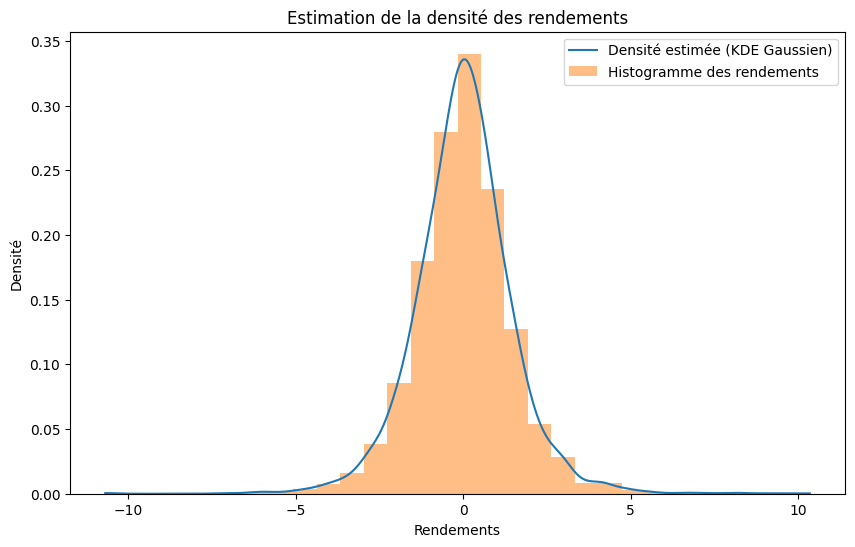

In [ ]:
def kernel_density_estimate(x, data, bandwidth):
    data = np.array(data)[:, np.newaxis]  # Convertit data en tableau 2D (colonne)
    x = np.atleast_1d(x)[np.newaxis, :]  # Assure que x est traité comme un tableau 1D, même s'il est scalaire
    kernel_vals = norm.pdf((x - data) / bandwidth)
    return np.sum(kernel_vals, axis=0) / (len(data) * bandwidth)

def kernel_density_estimate2(x, data, bandwidth):
    data = np.array(data)[:, np.newaxis]  # Convert data to 2D array (column)
    x = np.atleast_1d(x)[np.newaxis, :]  # Ensure x is treated as a 1D array
    kernel_vals = norm.pdf((x - data) / bandwidth)
    density = np.sum(kernel_vals, axis=0) / (len(data) * bandwidth)
    dx = x[0, 1] - x[0, 0]
    density /= np.sum(density) * dx  # Normalize
    return density

x = np.linspace(min(returns), max(returns), 1000)
initial_bandwidth = 0.3

# Estimation de la densité par noyau
kernel = kernel_density_estimate(x, returns, initial_bandwidth)

# Tracer la distribution estimée
plt.figure(figsize=(10, 6))
plt.plot(x, kernel, label="Densité estimée (KDE Gaussien)")
plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des rendements")
plt.xlabel('Rendements')
plt.ylabel('Densité')
plt.title('Estimation de la densité des rendements')
plt.legend()
plt.show()

## Règles empiriques (ROT)

Les ROT peuvent servir de base pour entamer une analyse de la densité. Elles peuvent donner une première estimation ou une orientation avant d'affiner davantage la solution.

### Règle simple

In [ ]:
def simple_bandwidth(returns):
    n = len(returns)
    range_returns = np.max(returns) - np.min(returns)
    return (range_returns / np.sqrt(n))

### Règle de Silverman

In [ ]:
def silverman_bandwidth(returns):
    n = len(returns)
    std_dev = np.std(returns)
    iqr = np.subtract(*np.percentile(returns, [75, 25]))
    return (0.9 * min(std_dev, iqr/1.34) * n**(-1/5))
    #return (4 / (3 * n))**(1/5) * std_dev
    #return (4 / (n * (2 + 1))) ** (1 / 5) * std_dev

### Règle de Scott

In [ ]:
def scott_bandwidth(returns):
    n = len(returns)
    std_dev = np.std(returns)
    return (3.5 * std_dev * n**(-1/3))
    #return n ** (-1/5) * std_dev

### Comparaisons

0.3248354177375515
0.6046894815914773
0.4802938683913162


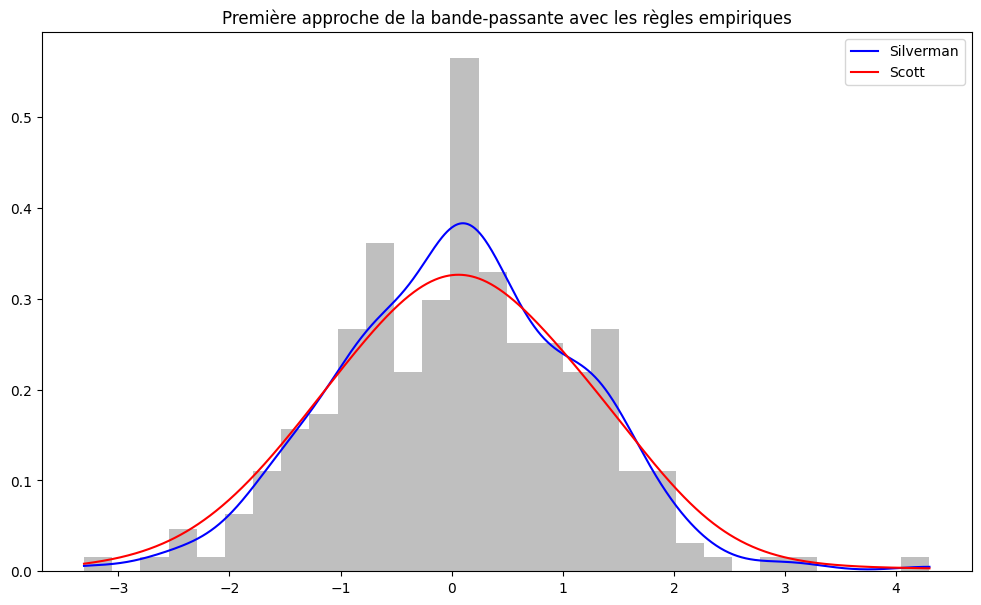

In [ ]:
# Calcul des bandes-passantes
h_silverman = silverman_bandwidth(returns)
h_scott = scott_bandwidth(returns)
h_simple = simple_bandwidth(returns)
print(h_silverman)
print(h_scott)
print(h_simple)

# Estimation des KDE
x = np.linspace(min(returns), max(returns), 1000)
kde_silverman = kernel_density_estimate(x, returns, h_silverman)
kde_scott = kernel_density_estimate(x, returns, h_scott)
kde_simple = kernel_density_estimate(x, returns, h_simple)
# Plot
plt.figure(figsize=(12, 7))
plt.title("Première approche de la bande-passante avec les règles empiriques")
plt.plot(x, kde_silverman, label="Silverman", color='blue')
plt.plot(x, kde_scott, label="Scott", color='red')
plt.hist(returns, bins=30, density=True, alpha=0.5, color='gray')
plt.legend()
plt.show()

Conclusion : On est loin d'avoir une approximation fiable avec ces règles empirique. Cependant, elles nous permettent d'avoir une première idée de la bande-passante.

## Influence de la bande-passante

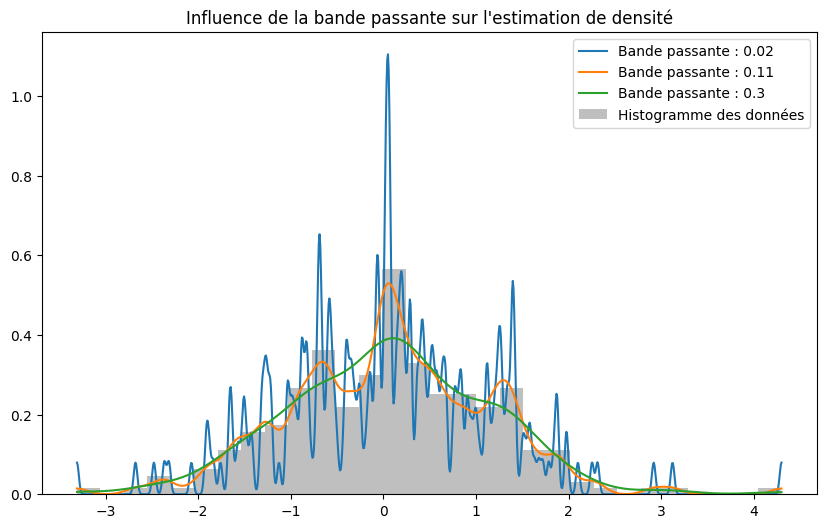

In [ ]:
# Importance du choix de la bande passante
bandwidths = [0.02, 0.11, 0.3]
x = np.linspace(min(returns), max(returns), 1000)  # Définition de l'espace des valeurs x pour l'évaluation

plt.figure(figsize=(10, 6))
for bw in bandwidths:
    kde = kernel_density_estimate(x, returns, bw)
    plt.plot(x, kde, label=f"Bande passante : {bw}")

plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des données", color="grey")
plt.legend()
plt.title("Influence de la bande passante sur l'estimation de densité")
plt.show()

Conclusion : La bande-passante est essentielle pour approcher au mieux la densité.

## Type de KDE (Bande-passante fixé)


On observe les courbes des différents noyaux (Gaussien, Taphat, Epanechnikov, exponentielle, linéaire, cosinus), en fixant la bande-passante à h=0,2

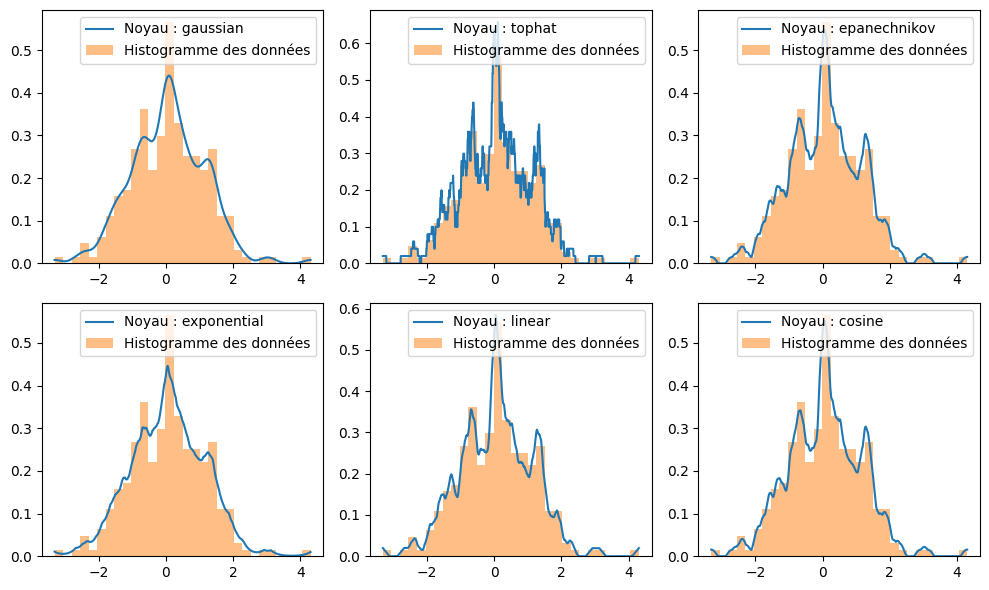

In [ ]:
def kernel_density(x, data, bandwidth, kernel):
    data = np.array(data)[:, np.newaxis]
    x = np.atleast_1d(x)[np.newaxis, :]

    if kernel == 'gaussian':
        kernel_vals = (1 / (np.sqrt(2 * np.pi) * bandwidth)) * np.exp(-0.5 * ((x - data) / bandwidth) ** 2)
    elif kernel == 'tophat':
        kernel_vals = uniform.pdf((x - data) / bandwidth, loc=-0.5, scale=1) / bandwidth
    elif kernel == 'epanechnikov':
        kernel_vals = np.where(np.abs(x - data) <= bandwidth, 0.75 * (1 - ((x - data) / bandwidth) ** 2) / bandwidth, 0)
    elif kernel == 'exponential':
        kernel_vals = np.exp(-np.abs(x - data) / bandwidth) / (2 * bandwidth)
    elif kernel == 'linear':
        kernel_vals = np.where(np.abs(x - data) <= bandwidth, (1 - np.abs(x - data) / bandwidth) / bandwidth, 0)
    elif kernel == 'cosine':
        kernel_vals = np.where(np.abs(x - data) <= bandwidth, (np.pi / 4) * np.cos(np.pi * (x - data) / (2 * bandwidth)) / bandwidth, 0)

    return np.sum(kernel_vals, axis=0) / len(data)

# Différents types de fonctions de noyau
kernels = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']

x = np.linspace(min(returns), max(returns), 1000)
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.ravel()

for i, kernel in enumerate(kernels):
    log_dens = kernel_density(x, returns, 0.2, kernel)
    axs[i].plot(x, log_dens, label=f"Noyau : {kernel}")
    axs[i].hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des données")
    axs[i].legend()

plt.tight_layout()
plt.show()


Conclusion : Les differents noyaux donnent des approximation plus ou moins sensible de la densité.

##A. Approche Amise & LOOCV

###Amise

But : Minimiser l'erreur quadratique intégrée moyenne entre l'estimateur de densité par noyau et la vraie densité inconnue.

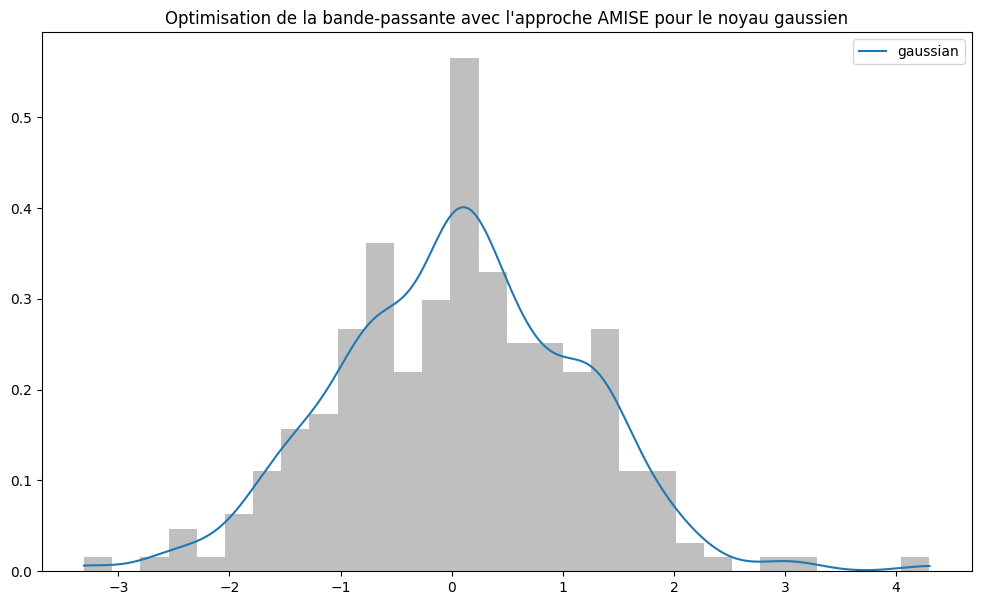

In [ ]:
def amise_bandwidth(data, kernel):
    n = len(data)

    if kernel == 'gaussian':
        R_K2 = 1 / np.sqrt(2* np.pi)
    elif kernel == 'epanechnikov':
        R_K2 = 3/5
    elif kernel == 'tophat':
        R_K2 = 1/2
    else:
        raise ValueError('Kernel not recognized.')

    std_dev = np.std(data)
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    h_prelim = 0.9 * min(std_dev, iqr/1.34) * n**(-1/5)

    R_f2 = 1

    h_amise = ((R_K2 / (n * R_f2)) ** (1/5))
    return h_amise

x = np.linspace(min(returns), max(returns), 1000)
plt.figure(figsize=(12, 7))
kernels=['gaussian', 'tophat', 'epanechnikov']

for kernel in kernels:
    h_amise = amise_bandwidth(returns, kernel)
    h_amise = max(h_amise, 1e-3)
    if kernel == 'gaussian':
        dens = kernel_density(x, returns, h_amise, kernel)
        plt.plot(x, dens, label=kernel)

# Plot
plt.title("Optimisation de la bande-passante avec l'approche AMISE pour le noyau gaussien")
plt.hist(returns, bins=30, density=True, alpha=0.5, color="grey")
plt.legend()
plt.show()

Conclusion :

### Approche LOOC

But : Choisir la bande passante qui maximise la probabilité du jeu de données observé, c'est-à-dire qui rend les données observées le plus "probables" possible sous l'estimateur de densité.

### Erreurs LOOC

In [ ]:
def looc1_error(returns, bandwidth, kernel):
    n = len(returns)
    errors = []

    for i in range(n):
        # Leave one out
        train = np.delete(returns, i)
        test = returns[i]

        # Préparer les points x pour l'évaluation KDE
        x = np.array([test])  # test est un scalaire, donc x est un tableau de ce seul point

        # Estimer la densité sans le i-ème point de données
        density = kernel_density(x, train, bandwidth, kernel)

        # Calculer l'erreur pour le point exclu
        epsilon = 1e-10  # Petite valeur pour éviter les problèmes numériques
        error = -np.log(density + epsilon)  # Utilisez directement la densité estimée

        errors.append(error)

    return np.mean(errors)


def best_approach(returns, kernel):
    bandwidths = np.linspace(0.1, 1.0, 50)
    min_error = float('inf')
    best_kernel = kernel[0]
    best_bandwidth = None

    for k in kernel:
        for bw in bandwidths:
            current_error = (looc1_error(returns, bw, k))
            if current_error < min_error:
                min_error = current_error
                best_kernel = k
                best_bandwidth = bw

    return best_kernel, best_bandwidth


kernels=['gaussian', 'tophat', 'epanechnikov']
best_kernel, best_bandwidth = best_approach(returns, kernels)


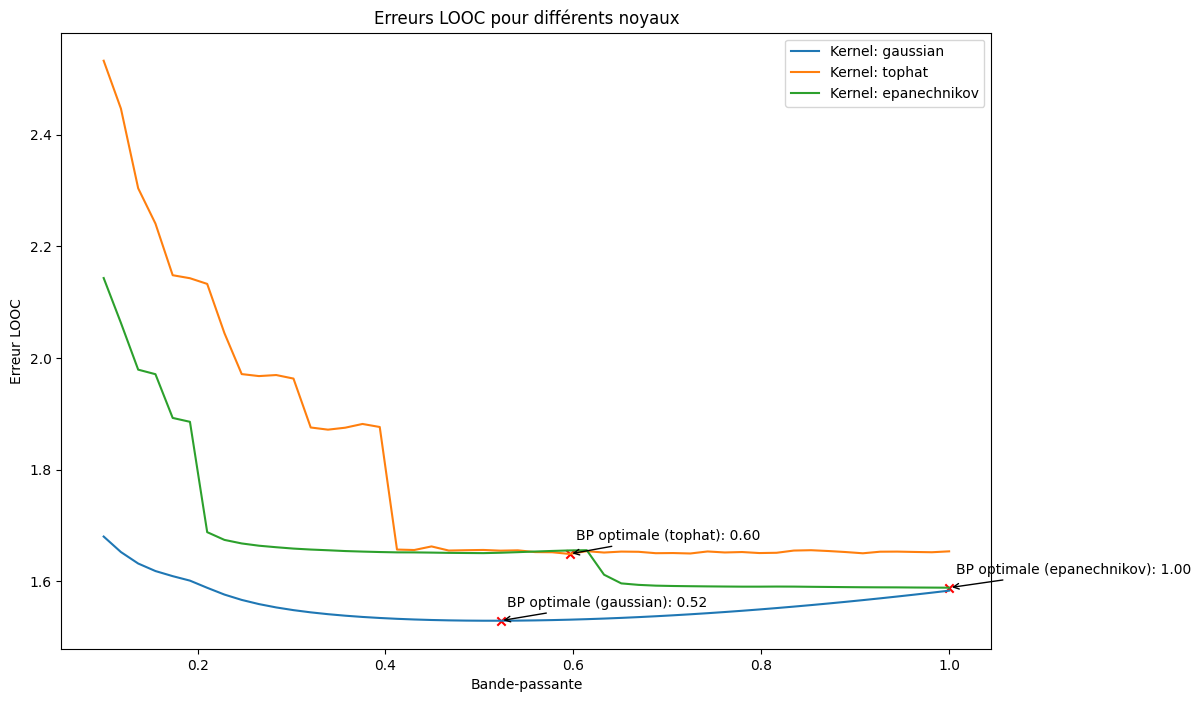

In [ ]:
def plot_looc1_errors(returns, kernel):
    bandwidths = np.linspace(0.1, 1.0, 50)  # Some range of bandwidths
    plt.figure(figsize=(12, 8))

    for kernel in kernel:
        errors = [looc1_error(returns, bw, kernel) for bw in bandwidths]
        plt.plot(bandwidths, errors, label=f'Kernel: {kernel}')

        # Indicate the bandwidth with the smallest LOOC error
        min_error_bandwidth = bandwidths[np.argmin(errors)]
        plt.scatter(min_error_bandwidth, np.min(errors), marker='x', color='red')
        plt.annotate(f'BP optimale ({kernel}): {min_error_bandwidth:.2f}', (min_error_bandwidth, np.min(errors)), xytext=(5,10), textcoords='offset points', arrowprops=dict(arrowstyle="->"))

    plt.title('Erreurs LOOC pour différents noyaux')
    plt.xlabel('Bande-passante')
    plt.ylabel('Erreur LOOC')
    plt.legend()
    plt.show()

kernel=['gaussian', 'tophat', 'epanechnikov']
plot_looc1_errors(returns, kernel)

### Approche de la densité

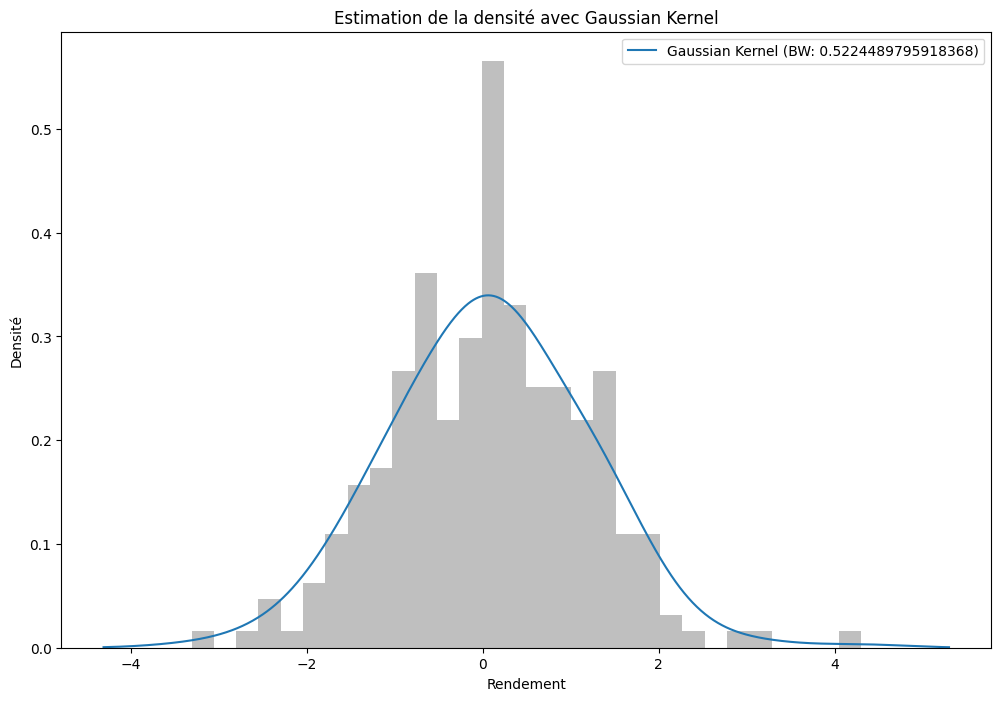

In [ ]:
def plot_best_density_estimation(returns, best_bandwidth, best_kernel):
    # Définir les paramètres pour le tracé
    x_plot = np.linspace(min(returns) - 1, max(returns) + 1, 1000)

    # Utiliser la fonction kernel_density_estimate pour calculer la densité estimée
    dens = kernel_density(x_plot, returns, best_bandwidth, best_kernel)

    # Tracer le graphique
    plt.figure(figsize=(12, 8))
    plt.plot(x_plot, dens, label=f'Gaussian Kernel (BW: {best_bandwidth})')
    plt.hist(returns, bins=30, density=True, alpha=0.5, color="grey")
    plt.title('Estimation de la densité avec Gaussian Kernel')
    plt.xlabel('Rendement')
    plt.ylabel('Densité')
    plt.legend()
    plt.show()

plot_best_density_estimation(returns, best_bandwidth, best_kernel)


##B. Partie MCMC

---



### Metropolis-Hasting (méthode MCMC)

In [ ]:
# Algorithme de Metropolis-Hastings
def metropolis_hastings(data, num_samples, bandwidth, proposal_width):
    # Sélection aléatoire d'un point de départ à partir des données
    current_sample = np.random.choice(data)
    samples = [current_sample]

    # Boucle pour générer les échantillons
    for i in range(num_samples - 1):
        # Proposition d'un nouvel échantillon basé sur le dernier échantillon accepté
        proposed_sample = np.random.normal(current_sample, proposal_width)

        # Calcul du rapport d'acceptation en utilisant la KDE
        acceptance_ratio = kernel_density_estimate(proposed_sample, data, bandwidth) / \
                           kernel_density_estimate(current_sample, data, bandwidth)

        # Accepter ou rejeter le nouvel échantillon basé sur le rapport d'acceptation
        if np.random.uniform() < acceptance_ratio:
            current_sample = proposed_sample


        samples.append(current_sample)


    return np.array(samples)

### Algorithme MCMC pour estimer la bande passante



In [ ]:
def kernel_density(x, data, bandwidth):
    return np.mean(norm.pdf((x - data) / bandwidth) / bandwidth)

def accept_reject(bandwidth, new_bandwidth, data):
    log_likelihood_old = np.sum(np.log(kernel_density(data, data, bandwidth)))
    log_likelihood_new = np.sum(np.log(kernel_density(data, data, new_bandwidth)))
    acceptance_ratio = np.exp(log_likelihood_new - log_likelihood_old)
    return acceptance_ratio > np.random.uniform()

def mcmc_bandwidth(data,kernel_density ,initial_bandwidth, n, proposal_width):
    current_bandwidth = initial_bandwidth
    accepted_samples = []
    for _ in range(n):
        new_bandwidth = current_bandwidth + np.random.normal(scale=proposal_width)
        if new_bandwidth > 0 and accept_reject(current_bandwidth, new_bandwidth, data):
            current_bandwidth = new_bandwidth
        accepted_samples.append(current_bandwidth)
    return accepted_samples

In [ ]:
initial_bandwidth = 0.2
n = 1000
proposal_width = 0.1
h = mcmc_bandwidth(data, kernel_density, initial_bandwidth, n, proposal_width)
h_mcmc = np.mean(h)
print(h_mcmc)

0.3350781808391237


###estimation de la densité initiale du dataset Nasdaq




In [ ]:
#paramètre de l'algo
num_samples = 10000
bandwidth = 0.1
proposal_width = h_mcmc

samples = metropolis_hastings(returns, num_samples, bandwidth, proposal_width)



Comparaison des échantillons MCMC avec les rendements réels


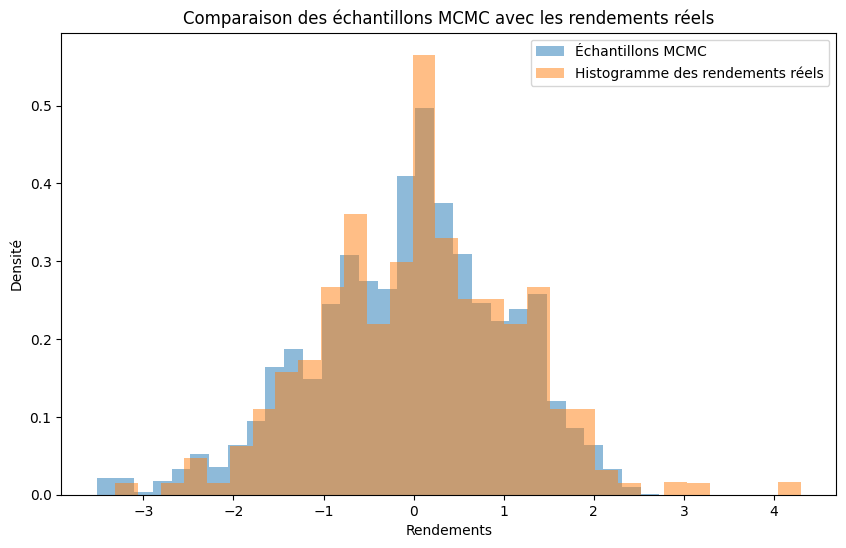

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(samples, bins=30, density=True, alpha=0.5, label="Échantillons MCMC")
plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des rendements réels")
plt.xlabel('Rendements')
plt.ylabel('Densité')
plt.title('Comparaison des échantillons MCMC avec les rendements réels')
plt.legend()
plt.show()

graph avec la densité des échantillons MCMC tracés


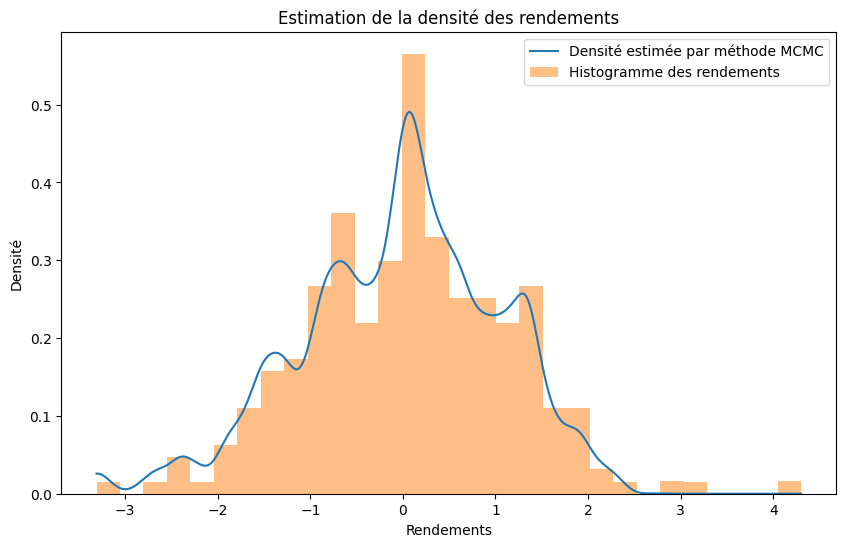

In [ ]:
# Estimer la densité
x = np.linspace(min(returns), max(returns), 1000)
density_values = kernel_density_estimate(x, samples, bandwidth)


plt.figure(figsize=(10, 6))
plt.plot(x, density_values, label="Densité estimée par méthode MCMC")
plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des rendements")
plt.xlabel('Rendements')
plt.ylabel('Densité')
plt.title('Estimation de la densité des rendements')
plt.legend()
plt.show()

Trace des échantillons générés par Metropolis-Hastings

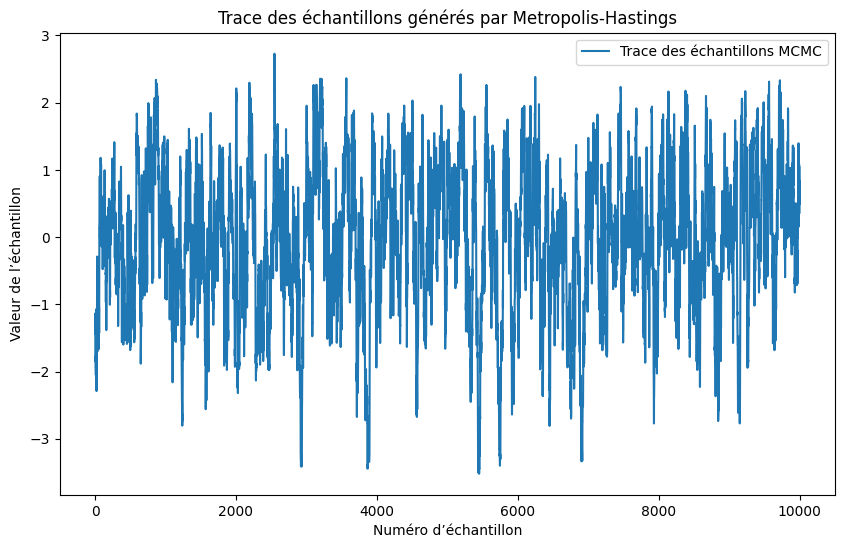

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(samples, label="Trace des échantillons MCMC")
plt.xlabel('Numéro d’échantillon')
plt.ylabel('Valeur de l’échantillon')
plt.title('Trace des échantillons générés par Metropolis-Hastings')
plt.legend()
plt.show()

##C. Partie PIT

---



Approche dynamique pour déterminer le noyau en fonction des poids

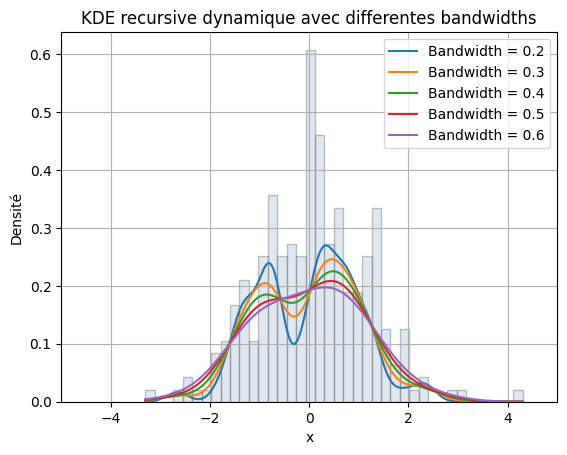

In [ ]:
# Fonction pour calculer la densité de probabilité normale
def norm_pdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

def rdk(returns, x, bandwidth, w, t0):
    t = len(returns)
    mu = returns.mean() # Calcul de la moyenne des rendements
    sigma = returns.std() # Calcul de l'écart-type des rendements

    # Calcul du poids initial
    weight = ((1 - w) * w ** (t - t0)) / (1 - w ** t0)

    # Initialisation de la valeur du noyau pour t0
    kernel_valeurs = weight * norm.pdf((x - returns[t0]) / bandwidth, mu, sigma) / bandwidth

    # Calcul des valeurs du noyau pour chaque point après t0
    for i in range(t0 + 1, t):
        kernel_valeurs = w * kernel_valeurs + ((1 - w) * norm.pdf((x - returns[i]) / bandwidth, mu, sigma)) / bandwidth

    return kernel_valeurs

x_valeurs = np.linspace(data['Daily_Return'].min(), data['Daily_Return'].max(), 1000)

# Liste des différentes valeurs de bandwidth pour la KDE
bandwidth_valeurs = [0.2, 0.3, 0.4, 0.5, 0.6]

# Tracer la distribution originale
plt.hist(data['Daily_Return'], bins=40, density=True, edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')

# Boucle sur les différentes valeurs de bandwidth pour la KDE
for bw in bandwidth_valeurs:
    recursive_KDE = [rdk(data['Daily_Return'], x, bw, 0.98, 200) for x in x_valeurs]
    plt.plot(x_valeurs, recursive_KDE, label=f'Bandwidth = {bw}')

plt.xlabel('x')
plt.ylabel('Densité')
plt.xlim(-5,5)
plt.grid(True)
plt.title('KDE recursive dynamique avec differentes bandwidths')
plt.legend()
plt.show()


Approche dynamique pour déterminer la fonction de répartition cumulative

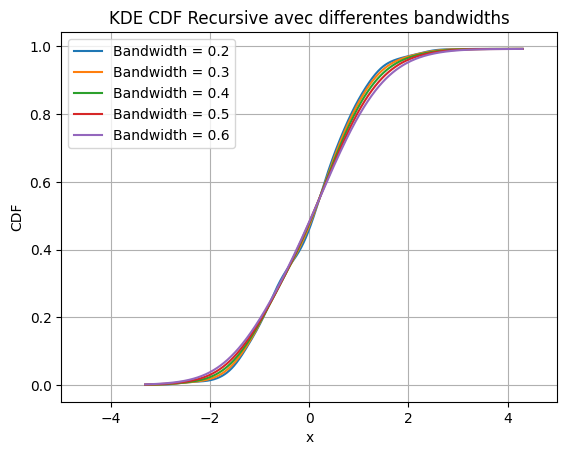

In [ ]:
def dynamique_kernel_cdf(data, x, bandwidth, w, t0):
    t = len(data)
    mu = data.mean()
    sigma = data.std()

    kernel_valeurs_cdf = 0
    for i in range(t0):
        cdf_value = norm.cdf((x - data[i]) / bandwidth, mu, sigma**0.5)
        kernel_valeurs_cdf += w**(t0-i) * cdf_value * ((1-w)/(1-w**t0))
    for i in range(t0+1, t):
        cdf_value = norm.cdf((x - data[i]) / bandwidth, mu, sigma**0.5)
        kernel_valeurs_cdf = w * kernel_valeurs_cdf + (1-w) * cdf_value

    return kernel_valeurs_cdf

x_valeurs = np.linspace(np.min(returns), np.max(returns), 1000)

# Boucle sur les différentes valeurs de bandwidth pour tracer la CDF
for bw in bandwidth_valeurs:
    recursive_CDF = [dynamique_kernel_cdf(returns, x, bw, 0.98, 200) for x in x_valeurs]
    plt.plot(x_valeurs, recursive_CDF, label=f'Bandwidth = {bw}')

plt.xlabel('x')
plt.ylabel('CDF')
plt.xlim(-5, 5)
plt.grid(True)
plt.title('KDE CDF Recursive avec differentes bandwidths')
plt.legend()
plt.show()


In [ ]:
def calcul_dynamique_cdf(t,h,w,t0):
  return dynamique_kernel_cdf(returns, returns[t],h,w,t0)

def uniform(dynamique_cdf_valeur,t0):
  T=len(dynamique_cdf_valeur)
  maximum = 0
  for s in range(t0+1,T):
    somme=0
    for u in range(t0+1,T):
      if(dynamique_cdf_valeur[u]>=0) and (dynamique_cdf_valeur[u]<= dynamique_cdf_valeur[s]):
        somme+=1
    diff=dynamique_cdf_valeur[s]- (1/(T-t0+1))*somme
    if abs(diff)>maximum:
      maximum=abs(diff)
  return maximum

def independance(dynamique_cdf_valeur, t0, tau):
  T=len(dynamique_cdf_valeur)
  maximum = 0
  for s in range(t0+1,T-tau):
    somme=0
    for u in range(t0+1,T-tau):
      if(dynamique_cdf_valeur[u]>=0) and (dynamique_cdf_valeur[u]<= dynamique_cdf_valeur[s]) and (dynamique_cdf_valeur[u+tau]>=0) and (dynamique_cdf_valeur[u+tau]<= dynamique_cdf_valeur[s+tau]):
        somme+=1
    diff=dynamique_cdf_valeur[s]*dynamique_cdf_valeur[s+tau]- (1/(T-tau-t0+1))*somme
    if abs(diff)>maximum:
      maximum=abs(diff)
  return maximum

def total(dynamique_cdf_valeur, t0, tau):
  if tau ==0:
    k=uniform(dynamique_cdf_valeur, t0)
  else:
    k=independance(dynamique_cdf_valeur, t0, tau)
  return k

def d_nu(dynamique_cdf_valeur, t0, nu):
    T = len(dynamique_cdf_valeur)
    max_val = float('-inf')
    for tau in range(nu + 1):
        if T - tau - t0 > 0:
            statistic = (((T - tau - t0)**0.5) * total(dynamique_cdf_valeur, t0, tau))
            if statistic > max_val:
                max_val = statistic
    return max_val

Approche permettant de déterminer la meilleure bandwidth et poids

In [ ]:
t0=200
nu=22

min_statistic= float('inf')
h_PIT=None
w_PIT=None

h_valeurs=np.linspace(0.3,0.8,6)
w_valeurs=np.linspace(1-(1/nu),0.99,15)

for h in h_valeurs:
  for w in w_valeurs:
    dynamique_cdf_valeur=[calcul_dynamique_cdf(t,h,w,t0) for t in range(t0+1, len(returns))]
    statistic = d_nu(dynamique_cdf_valeur,t0,nu)
    if statistic< min_statistic:
      min_statistic=statistic
      h_PIT=h
      w_PIT=w
print('Meilleure h:', h_PIT)
print('Meilleur w:', w_PIT)

x_valeurs=np.linspace(np.min(returns),np.max(returns),1000)
KDE_PIT=[rdk(returns, x, h_PIT, w_PIT, t0) for x in x_valeurs]

label="h="+str(h_PIT)+"w="+str(w_PIT)
plt.hist(returns, bins=40, density=True, edgecolor='dimgrey',alpha=0.4, color='lightsteelblue')
plt.plot(x_valeurs, KDE_PIT, color='firebrick')
plt.xlabel('x')
plt.ylabel('Density')
plt.xlim(-5,5)
plt.grid(True)
plt.title('KDE Optimisée')
plt.show

KeyboardInterrupt: 

##D. Paramètre libre par complexité

**Estimation du noyau de densité**

In [ ]:
def kernel_cdf(data, x, bandwidth, kernel='gaussian'):
    n = len(data)
    u = (x[:, np.newaxis] - data)/bandwidth

    if kernel == 'gaussian':
      S = np.mean(norm.cdf(u),axis=1)
    elif kernel == 'epanechnikov':
      i = (u > -1) & (u < 1)
      S = (3/4) * (u - u**3 / 3 + 0.5) * i
      S = np.mean(S, axis=1)
    elif kernel == 'rectangulaire':
      i = (abs(u) <= 1)
      S = (1/2) * i
      S = np.mean(S, axis=1)
    else :
      raise ValueError("Le noyau ne fonctionne pas")
    return S


x = np.linspace(min(returns), max(returns), 1000)
bandwidths1 = [0.02, 0.13, 0.3, 0.6, 1, 2, 4]
CDF = norm.cdf(x, 0, returns.std())

# Boucle sur les différentes valeurs de bandwidth pour tracer la CDF
for bw in bandwidths1:
  CDF_Gauss = kernel_cdf(returns, x, bw, kernel='gaussian')
  plt.plot(x, CDF, label="cdf théorique", color='black', linestyle='--')
  plt.plot(x, CDF_Gauss, label=f'Gaussien {bw}')
  plt.xlabel('x')
  plt.ylabel('CDF')
  plt.xlim(-5, 5)
  plt.grid(True)
  plt.title('KDE CDF Recursive avec differentes bandwidths')
  plt.legend()
  plt.show()

In [ ]:
# On fait le calcul de epsilon avec Kolmogorov-Smirnov
# Où epsilon est la divergence de la cdf par rapport à la distribution empirique


def epsilon_h(returns, x, bandwidth):
  F = kernel_cdf(returns, x, bandwidth)
  fde = np.arange(1, len(x) + 1) / len(x)
  diff_a = abs(F - fde)
  diff_b = abs(F - np.concatenate(([0], fde[:-1])))
  E = np.maximum(diff_a, diff_b)
  max_E = 0
  for i in range(len(E)):
    if E[i] > max_E:
      max_E = E[i]
  return max_E


# On fait le calcul de P_h avec Kullback-Leibler
# Où P_h est la divergence du noyau de densité par rapport à la distribution paramétrique

def P_h(F_h,G_theta):
  sum = 0
  for i in range(len(F_h)):
    sum += (F_h[i] * np.log(F_h[i]/G_theta[i]))
  return sum

In [ ]:
# Méthode du maximum de vraisemblance

def likelihood(moments ,returns):
  mu, sigma = moments
  n = len(returns)
  log_like = -n/2 * np.log(2 * np.pi) - n/2 * np.log(sigma**2) - 1/(2 * sigma**2) * np.sum((returns - mu)**2)
  return -log_like

# Estimation MLE de la moyenne et de la variance
result = minimize(likelihood, [np.mean(returns), np.std(returns)], args=(returns,), method='L-BFGS-B', bounds=[(None, None), (1e-6, None)])
mu_chapeau, sigma_chapeau = result.x

print(f"mu_chapeau = {mu_chapeau}, sigma_chapeau = {sigma_chapeau}")

In [ ]:
bandwidths2 = [0.013, 0.08, 0.13, 0.3, 0.6, 1, 2, 4, 6]

#Pour calculer le P_h de plusieurs bandwidths

def P_h_liste(bandwidths2, returns, x, mu_chapeau, sigma_chapeau):
  p_h = []
  for i in bandwidths2:
    F = kernel_cdf(returns, x, i)
    G = norm.cdf(x, mu_chapeau, sigma_chapeau)
    p_h.append(P_h(F,G))
  return p_h


p_h = P_h_liste(bandwidths2, returns, x, mu_chapeau, sigma_chapeau)

print(p_h)

In [ ]:
#Estimation de la bande-passante h_p

def h_p(p_h):
  return np.argmin(p_h)

H_p = h_p(p_h)
print(H_p)

hp = p_h[H_p]
print(f"La bande passante hp est égale à : {hp}")

In [ ]:
def max_epsilon(hp, returns, x):
  max_epsilon = 0
  for i in np.linspace(0.001, hp, 100):
    A = epsilon_h(returns, x, i)
    max_epsilon = max(max_epsilon, A)
  return max_epsilon


def max_P_h(returns, x, mu_chapeau, sigma_chapeau, hp):
  max_P_h = 0
  for i in np.linspace(0.001, hp, 100):
    F = kernel_cdf(returns, x, i)
    G = norm.cdf(x, mu_chapeau, sigma_chapeau)
    if(P_h(F, G)>max_P_h):
      max_P_h = P_h(F, G)
  return max_P_h


def C_h(returns, x, bandwidth, max_epsilon, max_P_h, F, G):
  e = epsilon_h(returns, x, bandwidth) / max_epsilon
  p = P_h(F, G) / max_P_h
  return(min(e, p))

Max_Epsilon = max_epsilon(hp, returns, x)
print(f"Epsilon max est égal à : {Max_Epsilon}")

Max_P_h = max_P_h(returns, x, mu_chapeau, sigma_chapeau, hp)
print(f"P_h max est égal à : {Max_P_h}")

In [ ]:
def maxi_C_h(hp, returns, x, max_epsilon, max_P_h, mu_chapeau, sigma_chapeau):
  c_h = []
  for i in np.linspace(0.001, hp, 100):
    F = kernel_cdf(returns, x, i)
    G = norm.cdf(x, mu_chapeau, sigma_chapeau)
    c_h.append(C_h(returns, x, i, max_epsilon, max_P_h, F, G))
  return c_h

Max_c_h = maxi_C_h(hp, returns, x, Max_Epsilon, Max_P_h, mu_chapeau, sigma_chapeau)
print(Max_c_h)

def h_c(Max_c_h):
  return np.argmax(Max_c_h)

hc = Max_c_h[h_c(Max_c_h)]
print(f"La bande passante h_c optimale est : {hc}")

#Partie 2 - version conditionnelle

## AMISE conditionnelle

On choisit comme variable conditionnelle le volume

In [ ]:
variable_conditionnelle = data['Volume']

# On normalise la variable conditionnelle avec une formule connue
variable_conditionnelle = (variable_conditionnelle - variable_conditionnelle.mean()) / variable_conditionnelle.std()

# On créer un tableau avec les rendements et la variable conditionnelle, ici le volume
combined_data = np.vstack([returns, variable_conditionnelle.values]).T

LOOCV conditionnelle

In [ ]:
from sklearn.model_selection import LeaveOneOut

def loocv_error_conditional(combined_data, bandwidth):
    loo = LeaveOneOut()
    errors = []

    # Boucle sur tous les échantillons, en laissant un échantillon dehors à chaque itération
    for train_index, test_index in loo.split(combined_data):
        # Séparation des données d'entraînement et de test
        train_data, test_data = combined_data[train_index], combined_data[test_index]

        # Adapter la densité de noyau à l'ensemble d'entraînement sans l'échantillon de test
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(train_data)

        # Calculer la log densité pour l'échantillon de test
        log_density = kde.score_samples(test_data)

        errors.append(-log_density)

    # Retourne la moyenne des erreurs LOOCV
    return np.mean(errors)

bandwidths = np.linspace(0.1, 1.0, 10)
best_bandwidth = None
best_error = float('inf')

# Recherche de la meilleure bande passante
for bandwidth in bandwidths:
    error = loocv_error_conditional(combined_data, bandwidth)
    if error < best_error:
        best_error = error
        best_bandwidth = bandwidth

print(f'Meilleure bande passante: {best_bandwidth}, Erreur LOOCV: {best_error}')


NameError: name 'combined_data' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Fonction pour calculer la bande passante AMISE pour le noyau Epanechnikov
def amise_bandwidth_conditional(combined_data):
    n = len(combined_data)

    # Estimation de la covariance des données combinées
    cov_matrix = np.cov(combined_data, rowvar=False)

    # Estimation robuste de la densité de probabilité
    R_f = np.linalg.det(cov_matrix) ** (1/6)

    # Calcul de la bande passante optimale pour le noyau Epanechnikov
    h_amise = (9 * R_f / (5 * n)) ** (1/7)

    return h_amise

# Utilisation de la fonction pour estimer la bande passante
h_amise_conditional = amise_bandwidth_conditional(combined_data)

# Estimation de la densité conditionnelle avec le noyau Epanechnikov
kde = KernelDensity(kernel='epanechnikov', bandwidth=h_amise_conditional).fit(combined_data)

# Grille pour la visualisation
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()
xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([xx.ravel(), yy.ravel()]).T

# Calcul des densités
densities = np.exp(kde.score_samples(positions)).reshape(xx.shape)

# Tracer la densité
plt.figure(figsize=(10, 8))
plt.imshow(np.rot90(densities), cmap="hot", extent=[x_min, x_max, y_min, y_max])
plt.colorbar()
plt.xlabel('Rendements')
plt.ylabel('Variable Conditionnelle (Volume)')
plt.title('Densité Estimée avec Bande Passante AMISE Conditionnelle (Noyau Epanechnikov)')
plt.show()

## Densité selon un seuil sur le volume

In [ ]:
# On créer un seuil correspondant a la mediane des volumes échangés
volume_threshold = data['Volume'].median()

above_threshold_returns = returns[data['Volume'] > volume_threshold]  # cas des rendements pour un volume échangé supérieur à la médiane calculée
below_threshold_returns = returns[data['Volume'] <= volume_threshold]  # cas des rendements pour un volume échangé inférieur ou égal à la médiane calculée

Avec noyau gaussien :

In [ ]:
# Estimate density for each subset of returns
kde_above = kernel_density_estimate(above_threshold_returns)
kde_below = kernel_density_estimate(below_threshold_returns)

x = np.linspace(min(returns), max(returns), 2000)

# Affichage des courbes de densité
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des rendements")
plt.plot(x, kde_above(x), label='Volume > Median')
plt.plot(x, kde_below(x), label='Volume <= Median')
plt.xlabel('Returns (%)')
plt.ylabel('Density')
plt.title('Densité Conditionnelle des Rendements avec Noyau Gaussien')
plt.legend()
plt.show()

TypeError: kernel_density_estimate() missing 2 required positional arguments: 'data' and 'bandwidth'

On obtient 2 courbes. La première représente la densité estimée des rendements selon les jours où la volume echangé est supérieur au volume median echangé.
La seconde représente la densité des rendements selon les jours où le volume echangé est inférieur ou égal au volume médian echangé.

Avec noyau d'Epanechnikov :

In [ ]:
from sklearn.neighbors import KernelDensity

# Fonction pour estimer la densité avec un noyau Epanechnikov
def estimate_density_epanechnikov(data):
    kde = KernelDensity(kernel='epanechnikov', bandwidth=0.5)
    kde.fit(data[:, None])
    return kde

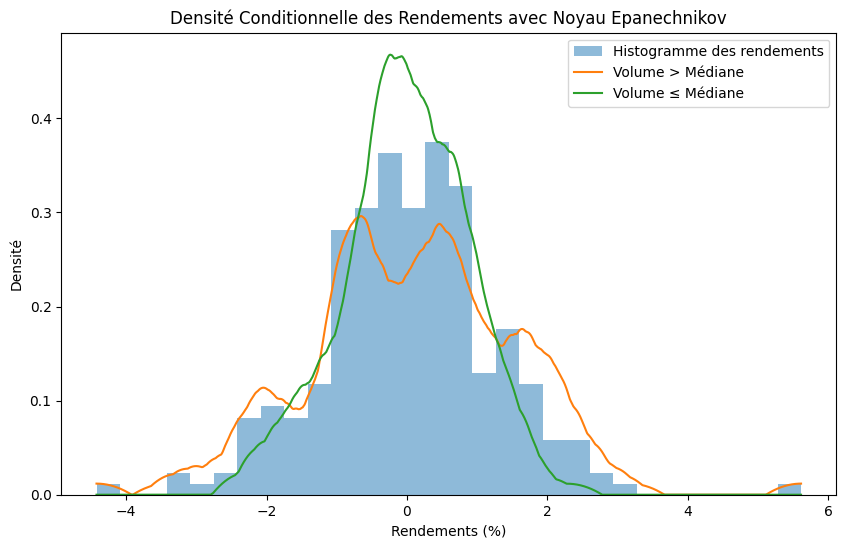

In [ ]:
# Estimer la densité pour chaque sous-ensemble de 'returns'
kde_above = estimate_density_epanechnikov(above_threshold_returns)
kde_below = estimate_density_epanechnikov(below_threshold_returns)

# Générer une plage de valeurs pour estimer la densité
x = np.linspace(min(returns), max(returns), 2000)

# valeurs de densité
density_above = np.exp(kde_above.score_samples(x[:, None]))
density_below = np.exp(kde_below.score_samples(x[:, None]))

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des rendements")
plt.plot(x, density_above, label='Volume > Médiane')
plt.plot(x, density_below, label='Volume ≤ Médiane')
plt.xlabel('Rendements (%)')
plt.ylabel('Densité')
plt.title('Densité Conditionnelle des Rendements avec Noyau Epanechnikov')
plt.legend()
plt.show()

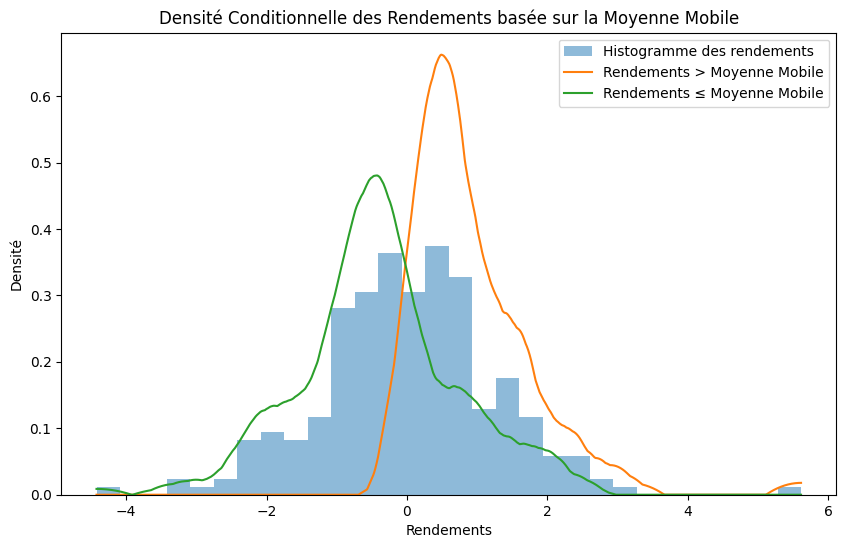

In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Calcul de la moyenne mobile sur 100 jours
moving_average = pd.Series(returns).rolling(window=100).mean()

# Création d'une variable conditionnelle
above_ma = returns > moving_average

# Séparation des rendements en fonction de la condition
above_ma_returns = returns[above_ma]
below_ma_returns = returns[~above_ma]

# Estimation de la densité pour chaque segment
kde_above = estimate_density_epanechnikov(above_ma_returns[~np.isnan(above_ma_returns)])
kde_below = estimate_density_epanechnikov(below_ma_returns[~np.isnan(below_ma_returns)])

# Génération d'une plage de valeurs pour l'estimation de la densité
x = np.linspace(np.nanmin(returns), np.nanmax(returns), 2000)

# Calcul des valeurs de densité
density_above = np.exp(kde_above.score_samples(x[:, None]))
density_below = np.exp(kde_below.score_samples(x[:, None]))

plt.figure(figsize=(10, 6))
plt.hist(returns, bins=30, density=True, alpha=0.5, label="Histogramme des rendements")
plt.plot(x, density_above, label='Rendements > Moyenne Mobile')
plt.plot(x, density_below, label='Rendements ≤ Moyenne Mobile')
plt.xlabel('Rendements')
plt.ylabel('Densité')
plt.title('Densité Conditionnelle des Rendements basée sur la Moyenne Mobile')
plt.legend()
plt.show()

### Bootstrap

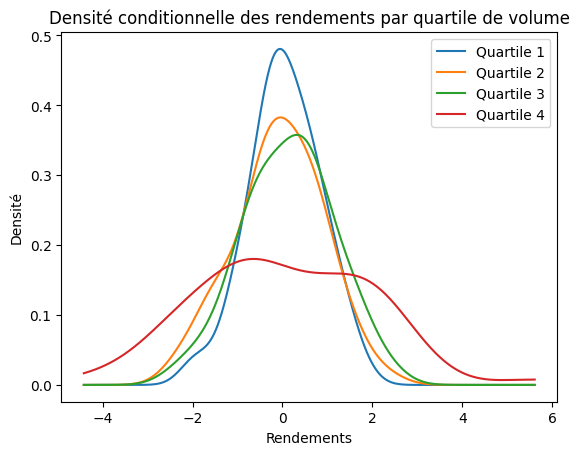

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

# Chargement des données
volume = data['Volume']  # Assumons que 'Volume' est notre variable d'intérêt

volume_quartiles = pd.qcut(volume, 4, labels=False)

# Pour chaque quartile, estimer et tracer la densité conditionnelle des rendements
x_grid = np.linspace(returns.min(), returns.max(), 1000)
for quartile in range(4):
    quartile_indices = volume_quartiles == quartile
    kde = gaussian_kde(returns[quartile_indices])
    plt.plot(x_grid, kde(x_grid), label=f'Quartile {quartile+1}')

plt.xlabel('Rendements')
plt.ylabel('Densité')
plt.title('Densité conditionnelle des rendements par quartile de volume')
plt.legend()
plt.show()

#Partie 3 - Application à un grand nombre de classes d’actifs

In [ ]:
def calculate_returns(data):
    if 'Close' in data.columns:
        return (data['Close'] - data['Open']) / data['Open'] * 100
    else:
        raise ValueError("Colonne 'Close' non trouvée dans les données")

action_symbols = ['AAPL', 'MC.PA', '0700.HK', 'PETR4.SA', '7203.T', 'SIE.DE', 'SAN', 'RELIANCE.NS', 'BHP', 'AZN']
indice_symbols = ['^GSPC', '^NDX', '^N225', '^GDAXI', '^DJI', '^FTSE']
comodity_symbols = ['GC=F', 'SI=F', 'ZW=F']
crypto_symbols = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'DOGE-USD']

def download_data(symbols, start_date, end_date):
    data = {}
    for symbol in symbols:
        df = yf.download(symbol, start=start_date, end=end_date)
        data[symbol] = calculate_returns(df.dropna())
    return data

def download_data2(symbols, start_date, end_date):
    data = {}
    for symbol in symbols:
        # Téléchargement des données pour le symbole spécifié
        df = yf.download(symbol, start=start_date, end=end_date)
        # Assurer que le DataFrame n'est pas vide
        if not df.empty:
            # Stockage direct des prix de clôture dans le dictionnaire
            data[symbol] = df['Close'].dropna()
        else:
            print(f"Aucune donnée téléchargée pour {symbol}.")
    return data

start_date = "2023-01-01"
end_date = "2024-01-01"

actions_data = download_data(action_symbols, start_date, end_date)
indices_data = download_data(indice_symbols, start_date, end_date)
comodities_data = download_data(comodity_symbols, start_date, end_date)
crypto_data = download_data(crypto_symbols, start_date, end_date)

In [ ]:
def estimate_density_with_method(returns, method):
    x = np.linspace(min(returns), max(returns), 1000)

    if method == 'AMISE':
        bandwidth = silverman_bandwidth(returns)
        density = kernel_density_estimate(x, returns, bandwidth)
    elif method == 'LOOCV':
        bandwidths = np.linspace(0.1, 1.0, 50)
        errors = [looc1_error(returns, bw, 'epanechnikov') for bw in bandwidths]
        bandwidth = bandwidths[np.argmin(errors)]
        density = kernel_density_estimate(x, returns, bandwidth)
    elif method == 'MCMC':
        bandwidth = silverman_bandwidth(returns)
        samples = metropolis_hastings(returns, num_samples=1000, bandwidth=bandwidth, proposal_width=0.1)
        density = kernel_density_estimate(x, samples, bandwidth)
    else:
        raise ValueError("Méthode non reconnue")

    return x, density

methods = ['AMISE', 'LOOCV', 'MCMC']


def plot_asset_density(data_dict, title):
    num_assets = len(data_dict)
    nrows = (num_assets + 1) // 2
    fig, axs = plt.subplots(nrows, 2, figsize=(15, 5 * nrows))

    print("\n")
    print("\033[1m" + title + "\033[0m")
    print("\n")

    for i, (asset_name, returns) in enumerate(data_dict.items()):
        if num_assets == 1:
            ax = axs
        else:
            row, col = i // 2, i % 2
            ax = axs[row, col] if nrows > 1 else axs[i]

        ax.hist(returns.dropna(), bins=30, density=True, alpha=0.5, label="Histogramme")
        for method in methods:
            x, density = estimate_density_with_method(returns.dropna().values, method)
            ax.plot(x, density, label=f"{method}")

        ax.set_title(f'Densités pour {asset_name}')
        ax.set_xlabel('Rendements')
        ax.set_ylabel('Densité')
        ax.legend()

    for j in range(i + 1, nrows * 2):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()


In [ ]:
plot_asset_density(actions_data, "Densité pour quelques actions")
plot_asset_density(comodities_data, "Densité pour quelques comodities")
plot_asset_density(indices_data, "Densité pour quelques indices")

In [ ]:
plot_asset_density(crypto_data, "Densité pour quelques cryptomonnaies")

#Partie 4 - Prévision des rendements d’une option et couverture


##Partie A

Chaque jour, un rendement quotidien R est appliqué au prix du jour précédent pour obtenir le prix du jour suivant.
• Le prix du jour i est calculé comme S; = Si-1 × (1 + Ri), où Si-1 est le prix du jour précédent et R; est le rendement du jour i.
• Cette opération est répétée pour chaque jour jusqu'à T.
• De manière équivalente, le prix final ST peut être calculé en un zul produit cumulatif: Sg = So × Ii-i(1 + Ri), où T est le nombre total de jours de trading dans le mois.
• Le prix d'un call et le prix d'un put sont déterminés par l'espérance du cash-flow actualisé, ce qui peut être exprimé comme suit :
• Pour un call: Cf = e(7-0)E|(ST - K)+]
• Pour un put : Pt = e-(I-E[(K - Sr)+]

* Calculez les rendements quotidiens à partir des cours de clôture historiques.

* Utilisez ces rendements pour simuler les futurs cours des actions.

* Utilisez les cours boursiers simulés pour calculer les valeurs des options à l'aide de la formule de Black-Scholes.

In [ ]:
data = pd.read_csv("MC.PA.csv", parse_dates=True, index_col='Date')

# Nettoyer les données pour enlever les NaN
data = data.dropna()

# Calculer le rendement quotidien
data['Daily_Return'] = (data['Close'] - data['Open']) / data['Open']*100
returns = data['Daily_Return'].values

In [ ]:
def simulate_prices (S0, daily_returns):
    n_days = len(daily_returns)
    prices = np.empty(n_days)
    prices[0] = S0
    for i in range(1,n_days):
      prev_price = prices[i-1]
      daily_return = daily_returns[i-1]
      new_price = prev_price * (1 + (daily_return/100))
      prices[i] = new_price
    return prices

def sample_returns(k, data, h):
    return np.random.choice(data, size=k, replace=True)

def get_k_price(k,data, last_price, h):
    sampled_returns = sample_returns(k,data, h)
    simulated_prices = simulate_prices(last_price, sampled_returns)
    return round(simulated_prices[k-1],3)

def n_simu(n, k, data, last_price, h):
    prices_simulation = []
    for p in range(n):
          prices_simulation.append(get_k_price(k, data, last_price, h))
    return prices_simulation

# Fonction Black-Scholes pour le pricing d'options
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Vega du modèle Black-Scholes
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

# Méthode de Newton-Raphson pour la volatilité implicite
def find_volatility_newton_raphson(market_price, S, K, T, r, initial_guess=0.2):
    sigma = initial_guess
    for _ in range(100):
        price_diff = black_scholes_call(S, K, T, r, sigma) - market_price
        v = vega(S, K, T, r, sigma)
        if v == 0: break
        sigma -= price_diff / v
        if abs(price_diff) < 1e-4: break
    return sigma


# Paramètres de simulation
nb_simu = 10000
k = 5
last_price = data["Close"].iloc[-1]
n_prices = n_simu(nb_simu, k, returns, last_price, silverman_bandwidth(returns))

strike_price_call = last_price * 1.05
strike_price_put = last_price * 0.95
T = 24 / 252  # Temps jusqu'à maturité en années
r = 0.04  # Taux sans risque
volatility = np.std(returns)

n_prices = n_simu(nb_simu, k, returns, last_price, silverman_bandwidth(returns))

option_prices = [black_scholes_call(price, strike_price_call, T, r, volatility) for price in n_prices]
volatilities = [find_volatility_newton_raphson(last_price, price, strike_price_call, T, r) for price in n_prices]
sigma_option = find_volatility_newton_raphson(last_price, last_price, strike_price_call, T, r, initial_guess=0.2)

<ipython-input-29-a52b7bfef30b>:28: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-29-a52b7bfef30b>:34: RuntimeWarning: overflow encountered in scalar power
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-29-a52b7bfef30b>:44: RuntimeWarning: overflow encountered in scalar divide
  sigma -= price_diff / v
<ipython-input-29-a52b7bfef30b>:28: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
<ipython-input-29-a52b7bfef30b>:34: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [ ]:
print(sigma_option)

36.441128586506174


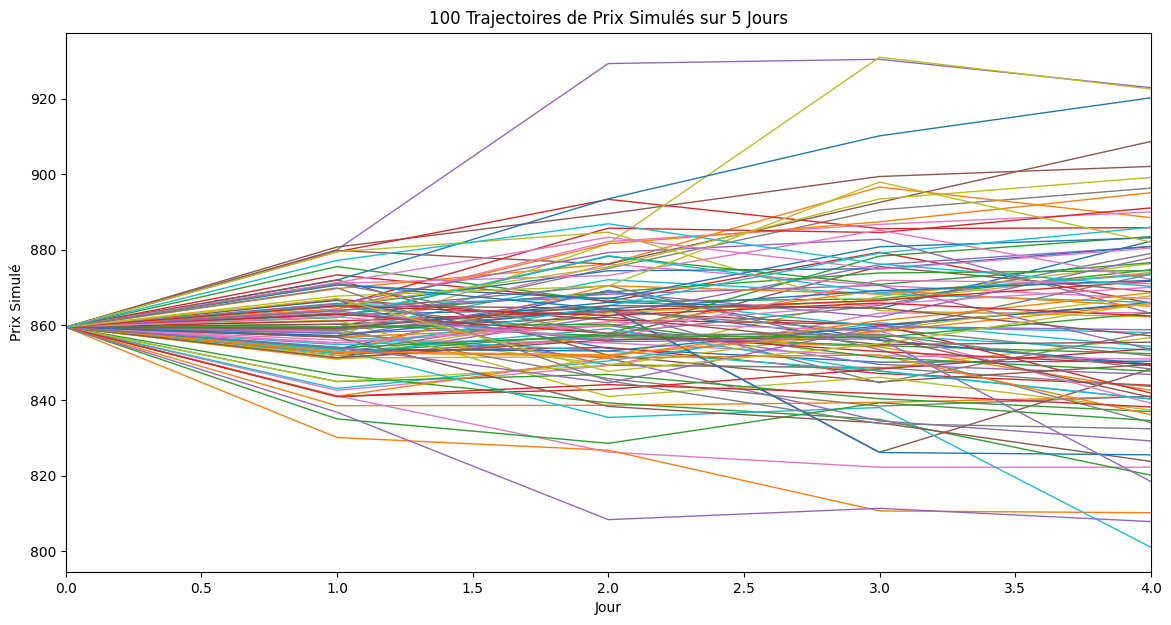

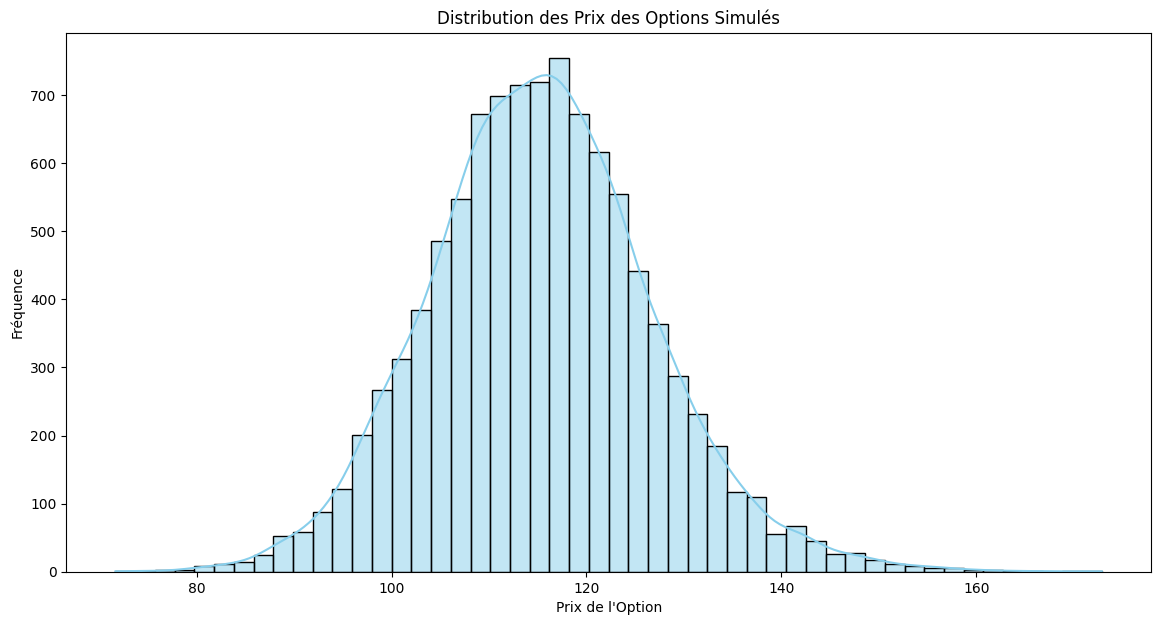

In [ ]:
def plot_simulated_prices(n, k, S0, returns, bandwidth):
    plt.figure(figsize=(14, 7))
    for _ in range(n):
        sampled_returns = sample_returns(k, returns, bandwidth)
        simulated_prices = simulate_prices(S0, sampled_returns)
        plt.plot(range(k), simulated_prices, lw=1)
    plt.title(f"{n} Trajectoires de Prix Simulés sur {k} Jours")
    plt.xlabel("Jour")
    plt.ylabel("Prix Simulé")
    plt.xlim(0, k-1)
    plt.show()

n=100
k = 5
plot_simulated_prices(n, k, last_price, returns, silverman_bandwidth(returns))

plt.figure(figsize=(14, 7))
sns.histplot(option_prices, kde=True, bins=50, color='skyblue')
plt.title("Distribution des Prix des Options Simulés")
plt.xlabel("Prix de l'Option")
plt.ylabel("Fréquence")
plt.show()

##Partie B

In [ ]:
def var_from_kde(returns, confidence_level, bandwidth):
    x = np.linspace(min(returns), max(returns), 1000)
    kde = kernel_density_estimate(x, returns, bandwidth)
    cdf = np.cumsum(kde) / np.sum(kde)
    var_index = np.where(cdf > confidence_level)[0][0]
    var = x[var_index]
    return -var

confidence_level = 0.05
bandwidth = silverman_bandwidth(returns)
var_from_kde(returns, confidence_level, bandwidth)

2.0815143743210953

In [ ]:
def cvar_from_kde(returns, var):
    filtered_returns = returns[returns <= -var]
    cvar = np.mean(filtered_returns)
    return cvar

var = 1.7553813862330645
confidence_level = 0.05
bandwidth = silverman_bandwidth(returns)
cvar = cvar_from_kde(returns, var)
print("CVaR:", cvar)

In [ ]:
def garch_forecast(returns, a0, a1, b1):
    n = len(returns)
    var_forecast = np.zeros(n)
    var_forecast[0] = np.var(returns)

    for t in range(1, n):
        var_forecast[t] = a0 + a1 * (returns[t-1] ** 2) + b1 * var_forecast[t-1]

    return var_forecast

a0 = 0.00001
a1 = 0.1
b1 = 0.8
garch_forecast(returns, a0, a1, b1)

In [ ]:
forecasted_volatility = garch_forecast(returns, a0, a1, b1)

plt.figure(figsize=(10, 6))
plt.plot(forecasted_volatility, color='blue', label='Forecasted Volatility')
plt.xlabel('Time Step')
plt.ylabel('Volatility')
plt.title('Forecasted Volatility using GARCH Model')
plt.legend()
plt.grid(True)
plt.show()

À revoir :

In [ ]:
def expected_return_option(option_price, S, K, T, r):
    expected_return = (option_price / S) * np.exp(r * T) - (K / S)
    return expected_return

average_option_price = np.mean(option_prices)

expected_return = expected_return_option(average_option_price, last_price, strike_price_call, T, r)

print(f"L'espérance de rendement de l'option d'achat est de {expected_return:.4f}")
print(average_option_price)
print(option_prices)

L'espérance de rendement de l'option d'achat est de -0.9153
115.35308537095946
[99.37323722142798, 120.14669248395313, 110.73141731787172, 99.14466621209556, 108.2513853762066, 103.8066388471633, 107.09873432112948, 130.50305994841472, 122.67966910308849, 132.7959627067986, 114.97565761617545, 126.75977490854052, 106.29379128560487, 121.5519430388511, 119.363014197648, 97.15379750056763, 102.50690218809086, 107.59753972065653, 120.84859555385549, 106.07965738037075, 110.68247828244404, 111.24279765160418, 108.02910125652409, 92.97268165653958, 132.2255048029062, 129.740909094147, 117.67650772649722, 120.8067404712171, 117.8407632385049, 116.30835237197135, 109.1733173218314, 130.41338448730846, 118.42192442789064, 125.21003199201954, 118.60823483958609, 108.59503870202161, 125.19067673799577, 106.39175369546649, 118.98236459777593, 115.39141074954574, 124.0881589297145, 121.39662228371282, 95.25564137482166, 103.44255677442169, 124.18288534722336, 124.71167945432842, 109.18210663037019

In [ ]:
def expected_return_option(option_price, S, K, T, r):
    expected_return = (option_price / S) * np.exp(r * T) - (K / S)
    return expected_return

average_option_price = np.mean(option_prices)

expected_return2 = expected_return_option(average_option_price, last_price, strike_price_put, T, r)

print(f"L'espérance de rendement de l'option de vente est de {expected_return2:.4f}")
print(average_option_price)
print(option_prices)

## Partie C

In [ ]:
def delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

option_delta = delta(last_price, strike_price_call, T, r, sigma_option)
option_delta_put = delta(last_price, strike_price_put, T, r, sigma_option)
print(option_delta)
print(option_delta_put)

0.9999999903960685
0.9999999908785263


In [ ]:
from scipy.stats import norm
import numpy as np

def delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    else:
        raise ValueError("Invalid option type. Please choose 'call' or 'put'.")
    return delta

option_delta_call = delta(last_price, strike_price_call, T, r, sigma_option, option_type='call')
option_delta_put = delta(last_price, strike_price_put, T, r, sigma_option, option_type='put')

print(option_delta_call)
print(option_delta_put)


0.9999999903960685
-9.121473687478954e-09


Les résultats indiquent que l'option a une sensibilité élevée aux variations du prix de l'actif sous-jacent. Cela signifie que pour chaque augmentation de 1 du prix de l'actif sous-jacent, le prix de l'option devrait augmenter de 0,999$, ce qui suggère que l'option est profondément dans la monnaie pour un call

In [ ]:
def vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

option_vega = vega(last_price, strike_price_call, T, r, sigma_option)
print(option_vega)

1.474056137022787e-05


Les resultats indiquent que le prix de l'option n'est pas significativement affectée par les changements de volatilité. Une augmentation de 1 % de la volatilité ne devrait entraîner qu'une augmentation très faible du prix de l'option, soit environ 3 * 10^(-5) unités

In [ ]:
import numpy as np
from scipy.optimize import minimize

delta_call = 0.999  # Delta de l'option d'achat
vega_call = 0.00003  # Vega de l'option d'achat
delta_put = -0.01   # Delta de l'option de vente
vega_put = 0.00003  # Vega de l'option de vente
delta_target = 0    # Objectif de delta pour le portefeuille
vega_target = 0 # Objectif de vega pour le portefeuille

# Fonction de coût à minimiser
def cost_function(x):
    n_calls, n_puts, n_shares = x
    # Calculer le delta et le vega du portefeuille
    portfolio_delta = n_calls * delta_call + n_puts * delta_put + n_shares
    portfolio_vega = n_calls * vega_call + n_puts * vega_put
    # Fonction de coût basée sur la différence carrée par rapport aux objectifs
    delta_diff = (portfolio_delta - delta_target) ** 2
    vega_diff = (portfolio_vega - vega_target) ** 2
    return delta_diff + vega_diff

# Conditions initiales (nombre d'options d'achat et de vente, et d'actions)
x0 = np.array([100, 100, 100])

# Appel à la fonction d'optimisation
result = minimize(cost_function, x0, method='SLSQP', bounds=[(0, None), (0, None), (None, None)])

n_calls_opt, n_puts_opt, n_shares_opt = result.x

print(f"Nombre optimal d'options d'achat (calls) à détenir: {round(n_calls_opt)}")
print(f"Nombre optimal d'options de vente (puts) à détenir: {round(n_puts_opt)}")
print(f"Nombre optimal d'unités de l'actif sous-jacent à détenir: {round(n_shares_opt)}")


Nombre optimal d'options d'achat (calls) à détenir: 60
Nombre optimal d'options de vente (puts) à détenir: 102
Nombre optimal d'unités de l'actif sous-jacent à détenir: -59


In [ ]:
VAR_tolerance = 1.7  # VAR précédemment calculée

historical_losses = -np.sort(-returns)  # Tri décroissant des pertes

# Calculer la VAR empirique
empirical_VAR = np.percentile(historical_losses, 5)  # VAR empirique à 95% de confiance

# Vérifier si la VAR empirique est inférieure ou égale à la VAR tolérée
if empirical_VAR <= VAR_tolerance:
    print("Les résultats de la stratégie sont acceptables.")
    print("La VAR empirique est :", empirical_VAR)
    print("La VAR tolérée est :", VAR_tolerance)
else:
    print("Les résultats de la stratégie ne sont pas acceptables.")
    print("La VAR empirique est :", empirical_VAR)
    print("La VAR tolérée est :", VAR_tolerance)


#Partie 5 : Construction d’une stratégie systématique


##A. Créer un code pour le backtest de stratégies

In [ ]:
class Backtest:
    def __init__(self, prices, strategy_function, initial_cash=10000, strategy_params={}, transaction_cost=0.001):
        """
        Initialise une nouvelle instance de backtest.

        :param prices: Pandas DataFrame contenant les prix des actifs sur lesquels la stratégie sera testée.
        :param strategy_function: Fonction qui définit la stratégie de trading. Cette fonction doit retourner un DataFrame de positions.
        :param initial_cash: Montant initial de cash disponible pour le trading.
        :param strategy_params: Dictionnaire contenant les paramètres à passer à la fonction de stratégie.
        :param transaction_cost: Coût des transactions exprimé en pourcentage du montant de la transaction.
        """
        self.prices = prices
        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.positions = strategy_function(prices, **strategy_params)  # Appel de la fonction de stratégie pour déterminer les positions.
        self.portfolio_value = self.calculate_portfolio_value()  # Calcule la valeur du portefeuille sur toute la période.


    def calculate_portfolio_value(self):
        """
        Calcule et retourne la série temporelle de la valeur du portefeuille en prenant en compte les positions,
        les prix des actifs, et les coûts de transaction.
        """
        quantity_held = 0  # Quantité d'actifs détenue
        cash = self.initial_cash  # Cash disponible
        portfolio_values = []  # Pour enregistrer la valeur du portefeuille à chaque point dans le temps

        # Itération sur chaque position et calcul de la nouvelle valeur du portefeuille après chaque transaction
        for date, row in self.positions.iterrows():
            price = self.prices.loc[date]  # Prix de l'actif à la date courante
            signal = row['Signal']  # Signal de trading (-1, 0, 1)

            if signal > 0:  # Achat
                cost = cash * self.transaction_cost  # Calcul du coût de la transaction
                cash -= cost  # Soustraction du coût du cash disponible
                quantity_bought = (cash - cost) / price  # Calcul de la quantité d'actifs achetée
                quantity_held += quantity_bought  # Mise à jour de la quantité détenue
                cash -= quantity_bought * price  # Mise à jour du cash après achat

            elif signal < 0 and quantity_held > 0:  # Vente
                proceeds = quantity_held * price  # Calcul du produit de la vente
                cost = proceeds * self.transaction_cost  # Calcul du coût de la transaction
                cash += proceeds - cost  # Mise à jour du cash après vente
                quantity_held = 0  # Réinitialisation de la quantité d'actifs détenue

            # Calcul de la valeur du portefeuille (cash + valeur des actifs détenus)
            portfolio_value = cash + quantity_held * price
            portfolio_values.append(portfolio_value)

        # Création d'une série Pandas pour la valeur du portefeuille
        portfolio_value_series = pd.Series(portfolio_values, index=self.positions.index)
        return portfolio_value_series


    def calculate_max_drawdown(self, portfolio_values):
        """
        Calcule le drawdown maximal du portefeuille sur la période d'étude.
        """
        # Calcule le pic maximum (la valeur la plus élevée) du portefeuille jusqu'à chaque point dans le temps
        peak = portfolio_values.expanding(min_periods=1).max()
        # Calcule le drawdown comme la différence relative entre la valeur actuelle du portefeuille et le pic
        drawdown = (portfolio_values - peak) / peak
        # Le drawdown maximal est le plus petit (le plus négatif) des drawdowns calculés
        max_drawdown = drawdown.min()
        return max_drawdown

    def calculate_volatility(self, portfolio_values):
        """
        Calcule la volatilité annuelle des rendements du portefeuille.
        """
        # Calcule les rendements quotidiens du portefeuille
        daily_returns = portfolio_values.pct_change()
        # Calcule l'écart-type (standard deviation) des rendements quotidiens, puis annualise en multipliant par la racine carrée de 252 (jours ouvrables par an)
        volatility = daily_returns.std() * np.sqrt(252)
        return volatility

    def calculate_total_return(self, portfolio_values):
        """
        Calcule le rendement total du portefeuille sur la période d'étude.
        """
        # Le rendement total est calculé comme le changement relatif entre la dernière et la première valeur du portefeuille
        total_return = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
        return total_return


    def plot_performance(self, benchmark_start_period=0):
        """
        Affiche la performance du portefeuille stratégique et la compare à un benchmark.
        Le benchmark est représenté par la performance d'un investissement initial dans l'actif, sans trading.
        Le backtest du benchmark commence après une période spécifiée en paramètre.
        """
        # Calcul de la valeur du portefeuille benchmark à partir du point de départ spécifié
        initial_investment = self.initial_cash
        adjusted_prices = self.prices.iloc[benchmark_start_period:]  # Ajustement des prix pour commencer à partir du benchmark_start_period
        benchmark_portfolio_value = initial_investment * (adjusted_prices / adjusted_prices.iloc[0])

        # Ajustement de l'index du DataFrame pour le faire correspondre à celui de la stratégie
        benchmark_portfolio_value.index = self.prices.index[benchmark_start_period:]

        # Calcul et affichage des métriques de performance pour la stratégie et le benchmark
        strategy_max_drawdown = self.calculate_max_drawdown(self.portfolio_value)
        strategy_volatility = self.calculate_volatility(self.portfolio_value)
        strategy_total_return = self.calculate_total_return(self.portfolio_value)

        benchmark_max_drawdown = self.calculate_max_drawdown(benchmark_portfolio_value)
        benchmark_volatility = self.calculate_volatility(benchmark_portfolio_value)
        benchmark_total_return = self.calculate_total_return(benchmark_portfolio_value)

        print(f"Stratégie - Max Drawdown: {strategy_max_drawdown*100:.2f}%, Volatilité: {strategy_volatility*100:.2f}%, Rendement Total: {strategy_total_return*100:.2f}%")
        print(f"Benchmark - Max Drawdown: {benchmark_max_drawdown*100:.2f}%, Volatilité: {benchmark_volatility*100:.2f}%, Rendement Total: {benchmark_total_return*100:.2f}%")

        # Tracé de la performance du portefeuille stratégique et du benchmark
        plt.figure(figsize=(10, 6))
        plt.plot(self.portfolio_value, label='Valeur du portefeuille stratégique', color='blue')
        plt.plot(benchmark_portfolio_value, label='Valeur du portefeuille benchmark', linestyle='--', color='orange')
        plt.title('Performance du portefeuille')
        plt.xlabel('Date')
        plt.ylabel('Valeur du portefeuille')
        plt.legend()
        plt.show()



    def plot_densities(self):
        """
        Trace la densité des rendements mensuels de l'actif et du Benchmark.
        """
        # Calcul des rendements mensuels de la stratégie
        strategy_returns = self.portfolio_value.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)

        # Calcul des rendements mensuels du benchmark
        benchmark_returns = self.prices.pct_change().resample('M').agg(lambda x: (x + 1).prod() - 1)

        # Calcul des statistiques
        strategy_mean = strategy_returns.mean()
        strategy_variance = strategy_returns.var()
        strategy_median = strategy_returns.median()

        benchmark_mean = benchmark_returns.mean()
        benchmark_variance = benchmark_returns.var()
        benchmark_median = benchmark_returns.median()

        # Affichage des espérances et des variances
        print(f"Stratégie - Espérance: {strategy_mean:.4f}, Variance: {strategy_variance:.4f}")
        print(f"Benchmark - Espérance: {benchmark_mean:.4f}, Variance: {benchmark_variance:.4f}")

        # Estimation de la densité
        x_vals = np.linspace(min(strategy_returns.min(), benchmark_returns.min()),
                             max(strategy_returns.max(), benchmark_returns.max()), 1000)
        bandwidth = np.std(strategy_returns.dropna()) * (4/3)**0.2 * len(strategy_returns.dropna())**(-1/5)

        density_strategy = kernel_density_estimate2(x_vals, strategy_returns.dropna(), bandwidth)
        density_benchmark = kernel_density_estimate2(x_vals, benchmark_returns.dropna(), bandwidth)

        # Tracé des densités et des médianes
        plt.figure(figsize=(10, 6))
        plt.plot(x_vals, density_strategy, label='Densité des rendements de la stratégie', color='blue')
        plt.plot(x_vals, density_benchmark, label='Densité des rendements du benchmark', color='orange')
        plt.axvline(x=strategy_median, color='blue', linestyle='--', label='Médiane de la stratégie')
        plt.axvline(x=benchmark_median, color='orange', linestyle='--', label='Médiane du Benchmark')
        plt.xlabel('Rendements')
        plt.ylabel('Densité')
        plt.title('Comparaison des densités des rendements')
        plt.legend()
        plt.show()

##B. Stratégie à partir du rendement espéré

###Ésperance et Volatilité par noyau

In [ ]:
def calcule_esperance_volatilite(prices, window):
    """
    Calcule l'espérance et la volatilité des rendements d'un actif sur une période définie
    en utilisant l'estimation de densité par noyau (KDE).
    """
    esperance_list = []  # Pour stocker les valeurs d'espérance calculées
    volatilite_list = []  # Pour stocker les valeurs de volatilité calculées

    # Itération sur les prix pour calculer l'espérance et la volatilité pour chaque fenêtre
    for i in range(window, len(prices)):
        window_prices = prices[i-window:i]  # Extraction des prix pour la fenêtre actuelle
        rendements = window_prices.pct_change().dropna()  # Calcul des rendements et suppression des valeurs NaN

        # Utilisation de l'estimation par noyau seulement si nous avons suffisamment de données
        if len(rendements) > 1:
            bandwidth = scott_bandwidth(rendements)
            x = np.linspace(rendements.min(), rendements.max(), 100)
            kde = kernel_density_estimate(x, rendements, bandwidth)
            esperance = np.sum(x * kde) / np.sum(kde)
            volatilite = np.sqrt(np.sum((x**2) * kde) / np.sum(kde) - esperance**2)
        else:
            esperance = 0  # Espérance à 0 si pas assez de données
            volatilite = 0  # Volatilité à 0 si pas assez de données

        # Ajout des résultats dans les listes correspondantes
        esperance_list.append(esperance)
        volatilite_list.append(volatilite)

    # Création de DataFrames pour l'espérance et la volatilité avec les indices appropriés
    esperance_df = pd.DataFrame(esperance_list, index=prices.index[window:], columns=['Esperance'])
    volatilite_df = pd.DataFrame(volatilite_list, index=prices.index[window:], columns=['Volatilite'])

    return esperance_df, volatilite_df

###Stratégie

La strategie est :


* "acheter" si l'espérance des rendements est positive et au-dessus d'un certain seuil de volatilité
* "vendre" si l'espérance est négative et la volatilité est au-dessus du même seuil
* "ne rien faire" (conserver la position actuelle) dans les autres cas



In [ ]:
def strategie_esperance_volatilite(prices, window, vol_threshold):
    """
    Génère des signaux de trading basés sur l'espérance des rendements et la volatilité.
    """

    # Calcul de l'espérance et de la volatilité des rendements sur la fenêtre spécifiée.
    esperance, volatilite = calcule_esperance_volatilite(prices, window)

    # Initialisation du DataFrame des signaux avec des zéros (pas d'action par défaut).
    signal = pd.DataFrame(index=prices.index, columns=['Signal'])
    signal['Signal'] = 0

    # Itération sur chaque jour après la fenêtre initiale pour décider des actions à prendre.
    for i in range(window, len(signal)):
        # Achat si l'espérance des rendements est positive et la volatilité est supérieure au seuil.
        if esperance.iloc[i-window]['Esperance'] > 0 and volatilite.iloc[i-window]['Volatilite'] > vol_threshold:
            signal.iloc[i] = 1

        # Vente si l'espérance des rendements est négative (avec un seuil minimal) et la volatilité est supérieure au seuil.
        elif esperance.iloc[i-window]['Esperance'] < -0.001 and volatilite.iloc[i-window]['Volatilite'] > vol_threshold:
            signal.iloc[i] = -1

    return signal

###Test avec différents paramètres

In [ ]:
# Définition des plages pour les paramètres 'window' et 'vol_threshold' à tester.
windows = [10, 25, 50, 75, 100, 125, 150]
vol_thresholds = [0.005, 0.01, 0.015, 0.02]

# Initialisation d'un dictionnaire pour stocker les résultats de chaque configuration.
results = {}

# Boucle à travers chaque combinaison de 'window' et 'vol_threshold'.
for window in windows:
    for vol_threshold in vol_thresholds:
        # Configuration des paramètres pour la stratégie actuelle.
        strategy_params = {'window': window, 'vol_threshold': vol_threshold}

        # Initialisation de l'objet Backtest avec les paramètres de stratégie actuels.
        backtest = Backtest(data['Close'], strategie_esperance_volatilite, strategy_params=strategy_params)

        # Exécution du backtest et stockage de la valeur finale du portefeuille.
        final_portfolio_value = backtest.portfolio_value.iloc[-1]
        results[(window, vol_threshold)] = final_portfolio_value

# Conversion des résultats stockés dans un DataFrame pour une manipulation plus aisée.
results_df = pd.DataFrame(list(results.items()), columns=['Params', 'FinalPortfolioValue'])
# Extraction des paramètres 'window' et 'vol_threshold' pour faciliter l'analyse.
results_df['Window'] = results_df['Params'].apply(lambda x: x[0])
results_df['VolThreshold'] = results_df['Params'].apply(lambda x: x[1])
# Suppression de la colonne 'Params' maintenant que les informations sont extraites.
results_df.drop('Params', axis=1, inplace=True)

# Identification de la configuration donnant la valeur finale de portefeuille la plus élevée.
max_value_row = results_df.loc[results_df['FinalPortfolioValue'].idxmax()]

# Tracé des valeurs finales du portefeuille pour différentes configurations de seuil de volatilité.
for vol_threshold in vol_thresholds:
    subset = results_df[results_df['VolThreshold'] == vol_threshold]
    plt.plot(subset['Window'], subset['FinalPortfolioValue'], label=f'Vol Threshold {vol_threshold}')

# Marquage de la meilleure performance avec une croix rouge.
plt.scatter(max_value_row['Window'], max_value_row['FinalPortfolioValue'], color='red', s=100, label='Meilleure performance', marker='x')

# Configuration des éléments visuels du graphique.
plt.title('Performance du portefeuille pour différentes configurations')
plt.xlabel('Window')
plt.ylabel('Final Portfolio Value')
plt.legend()
plt.show()

# Affichage des détails de la meilleure configuration trouvée.
print(f"Meilleure configuration: Window = {max_value_row['Window']}, VolThreshold = {max_value_row['VolThreshold']}")

###Résultats pour les meilleurs paramètres

In [ ]:
#Configuration des paramètres de la stratégie avec les meilleures valeurs trouvées.
strategy_params = {
    'window': int(max_value_row['Window']),  # Conversion du paramètre 'window' en entier.
    'vol_threshold': float(max_value_row['VolThreshold'])  # Conversion du paramètre 'vol_threshold' en flottant.
}

#Création d'une nouvelle instance de 'Backtest' en utilisant la meilleure configuration trouvée.
backtest = Backtest(data['Close'], strategie_esperance_volatilite, strategy_params=strategy_params)

# Exécution de la méthode 'plot_performance' pour visualiser la performance de la stratégie de trading
# avec les paramètres optimisés, en la comparant également à un benchmark.
backtest.plot_performance()

##C. Modèle prédictif avec plusieurs statistiques dérivées de la densité estimée

###Stratégie 1 : Croisement des moyennes mobiles de la densité

Stratégie :

* Achat "all in" si la moyenne mobile courte de l'espérance croise au-dessus de la moyenne mobile longue (retournement de tendance à la hausse)
* Vente de la position si la moyenne mobile courte de l'espérance croise en dessous de la moyenne mobile longue (retournement de tendance à la baisse)

In [ ]:
def strategie_croisement_moyennes_mobiles(prices, window, vol_threshold, short_window, long_window):
    """
    Stratégie de trading basée sur le croisement de deux moyennes mobiles de l'espérance des rendements.
    """
    # Calcul de l'espérance des rendements en utilisant la fonction externe
    esperance, _ = calcule_esperance_volatilite(prices, window)

    # Calcul des moyennes mobiles courtes et longues de l'espérance des rendements
    esperance_short_ma = esperance['Esperance'].rolling(window=short_window, min_periods=1).mean()
    esperance_long_ma = esperance['Esperance'].rolling(window=long_window, min_periods=1).mean()

    # Initialisation du DataFrame des signaux avec des zéros
    signal = pd.DataFrame(index=prices.index, data=0, columns=['Signal'])

    # Identification des indices valides où les deux moyennes mobiles ont des valeurs non-NaN
    valid_indices = esperance_short_ma.dropna().index.intersection(esperance_long_ma.dropna().index)

    # Itération sur les indices valides pour générer des signaux de trading
    for i in valid_indices:
        current_idx = prices.index.get_loc(i)  # Obtention de la position actuelle dans l'index
        if current_idx > 0:  # Assure qu'il existe un indice précédent pour comparer
            prev_idx = prices.index[current_idx - 1]  # Obtention de l'indice précédent
            # Génération d'un signal d'achat si la moyenne mobile courte croise au-dessus de la moyenne mobile longue
            if esperance_short_ma.loc[i] > esperance_long_ma.loc[i] and esperance_short_ma.loc[prev_idx] <= esperance_long_ma.loc[prev_idx]:
                signal.at[i, 'Signal'] = 1
            # Génération d'un signal de vente si la moyenne mobile courte croise en dessous de la moyenne mobile longue
            elif esperance_short_ma.loc[i] < esperance_long_ma.loc[i] and esperance_short_ma.loc[prev_idx] >= esperance_long_ma.loc[prev_idx]:
                signal.at[i, 'Signal'] = -1

    return signal


####Optimisation des paramètres

In [ ]:
def plot_optimization_results(results_df, max_value_row):
    """
    Affiche les résultats de l'optimisation des paramètres de la stratégie.
    """
    plt.figure(figsize=(12, 6))
    for vol_threshold in results_df['VolThreshold'].unique():
        subset = results_df[results_df['VolThreshold'] == vol_threshold]
        plt.plot(subset['Window'], subset['FinalPortfolioValue'], label=f'Vol Threshold {vol_threshold}')

    plt.scatter(max_value_row['Window'], max_value_row['FinalPortfolioValue'], color='red', s=100, label='Meilleure performance', marker='x')
    plt.title('Performance du portefeuille pour différentes configurations')
    plt.xlabel('Window')
    plt.ylabel('Final Portfolio Value')
    plt.legend()
    plt.show()


def optimize_strategy_parameters(data_close, strategy_function, windows, vol_thresholds, short_windows, long_windows):
    """
    Optimise les paramètres de la stratégie de croisement des moyennes.
    """
    results = {}
    for window in windows:
        for vol_threshold in vol_thresholds:
            for short_window in short_windows:
                for long_window in long_windows:
                    if short_window < long_window:
                        strategy_params = {'window': window, 'vol_threshold': vol_threshold, 'short_window': short_window, 'long_window': long_window}
                        backtest = Backtest(data_close, strategy_function, strategy_params=strategy_params)
                        final_portfolio_value = backtest.portfolio_value.iloc[-1]
                        results[(window, vol_threshold, short_window, long_window)] = final_portfolio_value

    results_df = pd.DataFrame(list(results.items()), columns=['Params', 'FinalPortfolioValue'])
    results_df[['Window', 'VolThreshold', 'ShortWindow', 'LongWindow']] = pd.DataFrame(results_df['Params'].tolist(), index=results_df.index)
    results_df.drop('Params', axis=1, inplace=True)
    max_value_row = results_df.loc[results_df['FinalPortfolioValue'].idxmax()]

    return(max_value_row['Window'], max_value_row['VolThreshold'], max_value_row['ShortWindow'], max_value_row['LongWindow'],results_df, max_value_row)

def split_dataset(data, train_size):
    """
    Divise le dataset de manière continue en deux parties: entraînement et test.
    """
    # Calcul du nombre d'observations dans l'ensemble d'entraînement
    cutoff = int(len(data) * train_size)

    # Division du dataset
    train = data[:cutoff]
    test = data[cutoff:]

    return train, test

# Définir les plages des paramètres à tester pour la stratégie
windows = [10, 25, 50, 75, 100, 125, 150]  # Fenêtres pour le calcul de l'espérance
vol_thresholds = [0.005, 0.01, 0.015, 0.02]  # Seuils de volatilité
short_windows = [5, 10, 15]  # Fenêtres pour la moyenne mobile courte
long_windows = [20, 50, 100]  # Fenêtres pour la moyenne mobile longue
# Avant d'appeler la fonction d'optimisation, divisez votre dataset
data_train, data_test = split_dataset(data['Close'], train_size=0.5)

# Ensuite, utilisez data_train pour l'optimisation
y = optimize_strategy_parameters(data_train, strategie_croisement_moyennes_mobiles, windows, vol_thresholds, short_windows, long_windows)

print("Meilleure configuration : Window =", y[0], ", VolThreshold =", y[1], ", ShortWindow =", y[2], ", LongWindow =", y[3])




Meilleure configuration : Window = 150.0 , VolThreshold = 0.005 , ShortWindow = 5.0 , LongWindow = 20.0


####Resultats pour les paramètres associés

Stratégie - Max Drawdown: -77.02%, Volatilité: 37.27%, Rendement Total: 261.53%
Benchmark - Max Drawdown: -76.63%, Volatilité: 54.59%, Rendement Total: 543.82%


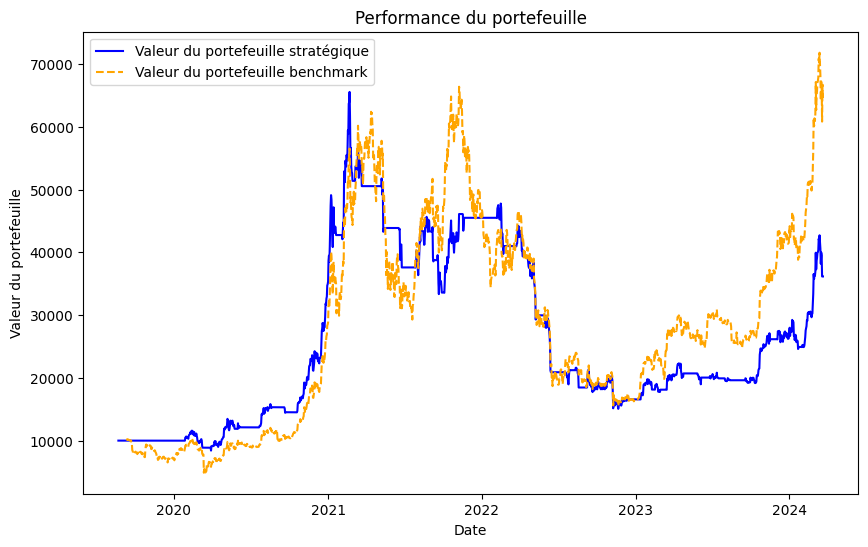

In [ ]:
# Configuration des paramètres de la stratégie avec les meilleures valeurs trouvées.
strategy_params = {
    'window': int(y[0]),  # La fenêtre de temps pour le calcul de l'espérance des rendements.
    'vol_threshold': float(y[1]),  # Le seuil de volatilité pour filtrer les signaux.
    'short_window': int(y[2]),  # La fenêtre pour la moyenne mobile courte.
    'long_window': int(y[3])  # La fenêtre pour la moyenne mobile longue.
}

# Création d'un nouvel objet 'Backtest' avec les paramètres optimisés.
backtest = Backtest(data_test, strategie_croisement_moyennes_mobiles, strategy_params=strategy_params)

# Exécution de la méthode 'plot_performance' pour visualiser la performance du portefeuille avec la stratégie optimisée.
backtest.plot_performance( benchmark_start_period=strategy_params['long_window'])

####Distribution des rendements mensuels de la strategie

In [ ]:
backtest.plot_densities()

####Application à une large gamme d'actifs

In [ ]:
def strat_assets_and_returns(data_dict, strategie, windows, vol_thresholds, short_windows, long_windows):
    returns_data = []

    for asset_name, data in data_dict.items():
        # S'assurer que la donnée est sous la forme attendue
        if isinstance(data, pd.DataFrame) and 'Close' in data.columns:
            close_prices = data['Close']
        elif isinstance(data, pd.Series):
            close_prices = data
        else:
            print(f"Les données pour {asset_name} ne sont pas dans un format attendu ou manquent la colonne 'Close'.")
            continue

        # Optimisation des paramètres de la stratégie pour l'actif courant
        y = optimize_strategy_parameters(close_prices, strategie, windows, vol_thresholds, short_windows, long_windows)
        strategy_params = {'window': int(y[0]), 'vol_threshold': float(y[1]), 'short_window': int(y[2]), 'long_window': int(y[3])}

        # Exécution de la stratégie
        backtest = Backtest(close_prices, strategie, strategy_params=strategy_params)

        # Exécution de la stratégie et tracé de sa performance
        backtest.plot_performance()

        # Calcul du rendement total de la stratégie en utilisant les valeurs du portefeuille
        strategy_returns = backtest.calculate_total_return(backtest.portfolio_value)


        # Calcul des rendements du benchmark (Buy and Hold)
        benchmark_returns = (close_prices.iloc[-1] / close_prices.iloc[0]) - 1

        # Compilation des résultats
        returns_data.append({
            'Asset': asset_name,
            'Strategy Return': strategy_returns,
            'Benchmark Return': benchmark_returns
        })

    # Conversion en DataFrame pour une manipulation facile
    returns_df = pd.DataFrame(returns_data)
    return returns_df

action_symbols = ['AAPL', 'MC.PA', '0700.HK', 'PETR4.SA', 'SAN', 'AZN']
indice_symbols = ['^GSPC', '^NDX', '^N225', '^GDAXI', '^DJI', '^FTSE']
comodity_symbols = ['GC=F', 'SI=F', 'ZW=F']
crypto_symbols = ['BTC-USD', 'ETH-USD']
#crypto_symbols = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'DOGE-USD']

start_date = "2021-01-01"
end_date = "2024-01-01"

actions_data = download_data2(action_symbols, start_date, end_date)
indices_data = download_data2(indice_symbols, start_date, end_date)
comodities_data = download_data2(comodity_symbols, start_date, end_date)
crypto_data = download_data2(crypto_symbols, start_date, end_date)

# Définir les plages des paramètres à tester pour la stratégie
windows = [10, 25, 50, 75, 100, 125, 150]  # Fenêtres pour le calcul de l'espérance
vol_thresholds = [0.005, 0.01, 0.015, 0.02]  # Seuils de volatilité
short_windows = [5, 10, 15]  # Fenêtres pour la moyenne mobile courte
long_windows = [20, 50, 100]  # Fenêtres pour la moyenne mobile longue

In [ ]:
strat_actions = strat_assets_and_returns(actions_data, strategie_croisement_moyennes_mobiles, windows, vol_thresholds, short_windows, long_windows)

In [ ]:
strat_crypto = strat_assets_and_returns(crypto_data, strategie_croisement_moyennes_mobiles, windows, vol_thresholds, short_windows, long_windows)

####Distribution des rendements sur l'ensembles des actifs


In [ ]:
def plot_distributions_from_df(returns_df, title):
    """
    Trace les distributions de rendements de la stratégie et du benchmark à partir du DataFrame
    """
    plt.figure(figsize=(10, 6))

    # Tracé de la distribution des rendements de la stratégie
    sns.kdeplot(returns_df['Strategy Return'], label='Stratégie', alpha=0.5, color='blue')

    # Tracé de la distribution des rendements du benchmark
    sns.kdeplot(returns_df['Benchmark Return'], label='Benchmark', alpha=0.5, color='orange')

    # Calcul et tracé de la médiane des rendements de la stratégie
    median_strategy = returns_df['Strategy Return'].median()
    plt.axvline(median_strategy, color='blue', linestyle='--', label=f'Médiane Stratégie: {median_strategy:.2f}')

    # Calcul et tracé de la médiane des rendements du benchmark
    median_benchmark = returns_df['Benchmark Return'].median()
    plt.axvline(median_benchmark, color='orange', linestyle='--', label=f'Médiane Benchmark: {median_benchmark:.2f}')

    plt.xlabel('Rendements')
    plt.ylabel('Densité')
    plt.title(title)
    plt.legend()
    plt.show()


plot_distributions_from_df(strat_actions, "Comparaison des distributions des rendements pour les actions")
#plot_distributions_from_df(strat_crypto, "Comparaison des distributions des rendements pour les cryptos")

###Stratégie 2 : Croisement des moyennes mobiles de la densité et short en cas de vente

Stratégie :

* Achat "all in" si la moyenne mobile courte de l'espérance croise au-dessus de la moyenne mobile longue (retournement de tendance à la hausse) et vente de l'éventuelle position courte
* Vente de la position si la moyenne mobile courte de l'espérance croise en dessous de la moyenne mobile longue (retournement de tendance à la baisse) et vente de l'éventuelle position longue

In [ ]:
def prepare_trading_data(prices, strategy_signals):
    """
    Prépare les données pour le trading en calculant les rendements journaliers
    et en associant les signaux de trading.
    """
    data = pd.DataFrame(index=prices.index)
    data['Price'] = prices
    data['Return'] = prices.pct_change()  # Calcul des rendements
    data['Signal'] = strategy_signals['Signal']
    return data

def calculate_portfolio_value_short(data, initial_cash=10000):
    """
    Calcule la valeur du portefeuille en prenant en compte les positions longues et courtes.

    :param data: DataFrame des prix, rendements et signaux.
    :param initial_cash: Montant initial du cash disponible pour le trading.
    :return: La série temporelle de la valeur du portefeuille.
    """
    cash = initial_cash
    quantity_held = 0  # Initialisé à 0, sera positif pour long et négatif pour short
    portfolio_values = [cash]

    for i in range(1, len(data)):
        signal = data['Signal'].iloc[i]
        daily_return = data['Return'].iloc[i]

        if signal != 0:  # Changement de position
            quantity_held = cash if signal > 0 else -cash
        # Application du rendement sur la position
        cash += quantity_held * daily_return
        portfolio_values.append(cash)

    return pd.Series(portfolio_values, index=data.index)


####Optimisation des paramètres

In [ ]:
def optimize_strategy_parameters_with_shorts(data_close, strategy_function, windows, vol_thresholds, short_windows, long_windows):
    """
    Optimise les paramètres de la stratégie de croisement des moyennes, tenant compte des positions courtes et longues.
    """
    best_performance = -np.inf
    best_params = None

    for window in windows:
        for vol_threshold in vol_thresholds:
            for short_window in short_windows:
                for long_window in long_windows:
                    if short_window < long_window:
                        strategy_signals = strategy_function(data_close, window, vol_threshold, short_window, long_window)
                        trading_data = prepare_trading_data(data_close, strategy_signals)
                        portfolio_values = calculate_portfolio_value_short(trading_data)
                        final_portfolio_value = portfolio_values.iloc[-1]

                        if final_portfolio_value > best_performance:
                            best_performance = final_portfolio_value
                            best_params = (window, vol_threshold, short_window, long_window)

    return best_params


####Résultats pour les meilleurs paramètres

In [ ]:
def calculate_max_drawdown(series):
    cumulative_returns = (1 + series).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

def calculate_annualized_volatility(series):
    daily_volatility = series.std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    return annualized_volatility

def calculate_total_return(series):
    total_return = (series.iloc[-1] / series.iloc[0]) - 1
    return total_return

In [ ]:
data_test,data_train=split_dataset(data, train_size=0.5)['Close']

Stratégie - Max Drawdown: -19.45%, Volatilité: 11.73%, Rendement Total: -23.23%
Benchmark - Max Drawdown: -76.63%, Volatilité: 54.58%, Rendement Total: 543.82%


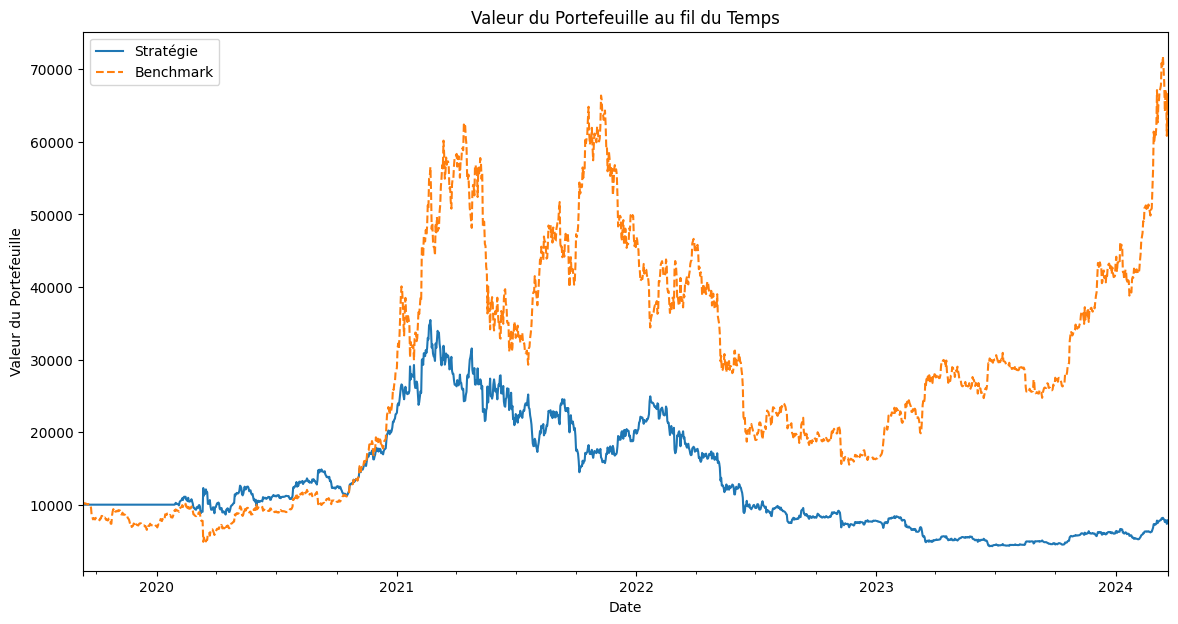

In [ ]:
#data_close = data['Close'].resample('D').ffill()

data_train, data_test = split_dataset(data['Close'], train_size=0.5)

windows = [10, 25, 50, 75, 100, 125, 150]  # Fenêtres pour le calcul de l'espérance
vol_thresholds = [0.005, 0.01, 0.015, 0.02]  # Seuils de volatilité
short_windows = [5, 10, 15]  # Fenêtres pour la moyenne mobile courte
long_windows = [20, 50, 100]  # Fenêtres pour la moyenne mobile longue


best_params = optimize_strategy_parameters_with_shorts(data_train, strategie_croisement_moyennes_mobiles, windows, vol_thresholds, short_windows, long_windows)
"""
best_params = strategy_params
"""
strategy_signals = strategie_croisement_moyennes_mobiles(data_test, *best_params)
trading_data = prepare_trading_data(data_test, strategy_signals)
portfolio_values = calculate_portfolio_value_short(trading_data)

initial_investment = 10000
benchmark_values = initial_investment * (data_test / data_test.iloc[0])

strategy_returns = trading_data['Return'] * trading_data['Signal'].shift(1)
strategy_max_drawdown = calculate_max_drawdown(strategy_returns)
strategy_volatility = calculate_annualized_volatility(strategy_returns)
strategy_total_return = calculate_total_return(portfolio_values)

"""
benchmark_returns = trading_data['Return']
benchmark_max_drawdown = calculate_max_drawdown(benchmark_returns)
benchmark_volatility = calculate_annualized_volatility(benchmark_returns)
benchmark_total_return = calculate_total_return(benchmark_values)

print(f"Stratégie - Max Drawdown: {strategy_max_drawdown*100:.2f}%, Volatilité: {strategy_volatility*100:.2f}%, Rendement Total: {strategy_total_return*100:.2f}%")
print(f"Benchmark - Max Drawdown: {benchmark_max_drawdown*100:.2f}%, Volatilité: {benchmark_volatility*100:.2f}%, Rendement Total: {benchmark_total_return*100:.2f}%")

# Plotting both the strategy's and the benchmark's portfolio values
plt.figure(figsize=(14, 7))
portfolio_values.plot(label="Stratégie")
benchmark_values.plot(label="Benchmark", linestyle='--')
plt.title("Valeur du Portefeuille au fil du Temps")
plt.xlabel("Date")
plt.ylabel("Valeur du Portefeuille")
plt.legend()
plt.show()

"""

# Spécifier le point de départ du benchmark
benchmark_start_index = strategy_params['long_window']

adjusted_data_close_for_benchmark = data_test[benchmark_start_index:]
benchmark_values = initial_investment * (adjusted_data_close_for_benchmark / adjusted_data_close_for_benchmark.iloc[0])

benchmark_returns = adjusted_data_close_for_benchmark.pct_change().fillna(0)
benchmark_max_drawdown = calculate_max_drawdown(benchmark_returns)
benchmark_volatility = calculate_annualized_volatility(benchmark_returns)
benchmark_total_return = calculate_total_return(benchmark_values)

print(f"Stratégie - Max Drawdown: {strategy_max_drawdown*100:.2f}%, Volatilité: {strategy_volatility*100:.2f}%, Rendement Total: {strategy_total_return*100:.2f}%")
print(f"Benchmark - Max Drawdown: {benchmark_max_drawdown*100:.2f}%, Volatilité: {benchmark_volatility*100:.2f}%, Rendement Total: {benchmark_total_return*100:.2f}%")

plt.figure(figsize=(14, 7))
portfolio_values[benchmark_start_index:].plot(label="Stratégie")  # Assurez-vous que les plages de dates correspondent
benchmark_values.plot(label="Benchmark", linestyle='--')
plt.title("Valeur du Portefeuille au fil du Temps")
plt.xlabel("Date")
plt.ylabel("Valeur du Portefeuille")
plt.legend()
plt.show()

In [ ]:
print(strategy_params['long_window'])

20


####Distribution des rendements mensuels de la strategie

In [ ]:
def plot_densities(strategy_returns,benchmark_returns):
    """
    Trace la densité des rendements mensuels de l'actif et du Benchmark.
    """
    # Calcul des statistiques
    strategy_mean = strategy_returns.mean()
    strategy_variance = strategy_returns.var()
    strategy_median = strategy_returns.median()

    benchmark_mean = benchmark_returns.mean()
    benchmark_variance = benchmark_returns.var()
    benchmark_median = benchmark_returns.median()

    # Affichage des espérances et des variances
    print(f"Stratégie - Espérance: {strategy_mean:.4f}, Variance: {strategy_variance:.4f}")
    print(f"Benchmark - Espérance: {benchmark_mean:.4f}, Variance: {benchmark_variance:.4f}")

    # Estimation de la densité
    x_vals = np.linspace(min(strategy_returns.min(), benchmark_returns.min()),
                          max(strategy_returns.max(), benchmark_returns.max()), 1000)
    bandwidth = np.std(strategy_returns.dropna()) * (4/3)**0.2 * len(strategy_returns.dropna())**(-1/5)

    density_strategy = kernel_density_estimate2(x_vals, strategy_returns.dropna(), bandwidth)
    density_benchmark = kernel_density_estimate2(x_vals, benchmark_returns.dropna(), bandwidth)

    # Tracé des densités et des médianes
    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, density_strategy/301,label='Densité des rendements de la stratégie', color='blue')
    plt.plot(x_vals, density_benchmark/301, label='Densité des rendements du benchmark', color='orange')
    plt.axvline(x=strategy_median, color='blue', linestyle='--', label='Médiane de la stratégie')
    plt.axvline(x=benchmark_median, color='orange', linestyle='--', label='Médiane du Benchmark')
    plt.xlabel('Rendements')
    plt.ylabel('Densité')
    plt.title('Comparaison des densités des rendements')
    plt.legend()
    plt.show()

In [ ]:
plot_densities(strategy_returns,benchmark_returns)

####Application à une large gamme d'actifs

In [ ]:
# Télécharger les données de l'actif
action_symbols = ['0700.HK']
start_date = "2021-01-01"
end_date = "2024-01-01"

# Téléchargement et préparation des données
data_hk = yf.download(action_symbols, start=start_date, end=end_date)
data_close = pd.DataFrame(data_hk['Close'].dropna())
data_close.index = pd.to_datetime(data_close.index)
data_close = data_close.asfreq('D', method='ffill')

for i in range(1, 9):  # This will create 8 columns
    data_close[f'Column_{i}'] = 0

data_close = data_close['Close'].resample('D').ffill()

# Définir les plages des paramètres à tester pour la stratégie
windows = [10, 25, 50, 75, 100, 125, 150]  # Fenêtres pour le calcul de l'espérance
vol_thresholds = [0.005, 0.01, 0.015, 0.02]  # Seuils de volatilité
short_windows = [5, 10, 15]  # Fenêtres pour la moyenne mobile courte
long_windows = [20, 50, 100]  # Fenêtres pour la moyenne mobile longue

best_params = optimize_strategy_parameters_with_shorts(data_close, strategie_croisement_moyennes_mobiles, windows, vol_thresholds, short_windows, long_windows)
strategy_signals = strategie_croisement_moyennes_mobiles(data_close, *best_params)
trading_data = prepare_trading_data(data_close, strategy_signals)
portfolio_values = calculate_portfolio_value_short(trading_data)

initial_investment = 10000
benchmark_values = initial_investment * (data_close / data_close.iloc[0])

strategy_returns = trading_data['Return'] * trading_data['Signal'].shift(1)
strategy_max_drawdown = calculate_max_drawdown(strategy_returns)
strategy_volatility = calculate_annualized_volatility(strategy_returns)
strategy_total_return = calculate_total_return(portfolio_values)

benchmark_returns = trading_data['Return']
benchmark_max_drawdown = calculate_max_drawdown(benchmark_returns)
benchmark_volatility = calculate_annualized_volatility(benchmark_returns)
benchmark_total_return = calculate_total_return(benchmark_values)

print(f"Stratégie - Max Drawdown: {strategy_max_drawdown*100:.2f}%, Volatilité: {strategy_volatility*100:.2f}%, Rendement Total: {strategy_total_return*100:.2f}%")
print(f"Benchmark - Max Drawdown: {benchmark_max_drawdown*100:.2f}%, Volatilité: {benchmark_volatility*100:.2f}%, Rendement Total: {benchmark_total_return*100:.2f}%")

# Plotting both the strategy's and the benchmark's portfolio values
plt.figure(figsize=(14, 7))
portfolio_values.plot(label="Stratégie")
benchmark_values.plot(label="Benchmark", linestyle='--')
plt.title("Valeur du Portefeuille au fil du Temps")
plt.xlabel("Date")
plt.ylabel("Valeur du Portefeuille")
plt.legend()
plt.show()